**MSc Computational Physics AUTh**<br>
**Academic Year: 2024-2025**<br>
**Master's Thesis**<br>

**Thesis Title:**<br>  
# **"Reconstruction of the EoSs of Exotic Stars using ML and ANNs regression models"**

**Implemented by: Ioannis Stergakis**<br>
**AEM: 4439**<br>

**Jupyter Notebook: JN9**<br>
**Name: "reconstruct_EOS_NS.ipynb"**<br>

**Description:**<br> 
**Reconstructing EOSs of Neutron Stars**


**Abbrevations:**<br>
**1. NS -> Neutron Star**<br>
**2. QS -> Quark Star**<br>
**3. ML -> Machine Learning**<br>
**4. DL -> Deep Learning**<br>
**5. DNN -> Deep Neural Network**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_log_error
from ExoticStarsDataHandling import *

# 1. Preliminaries

In [2]:
def predict_EOS_polyNS(axis_EOS,axis_MR,poly_EOS,reg_models_infos:np.ndarray,points_MR,Pc_points,iterations,include_Mmax=True):
    num_pcpoints = len(Pc_points)
    num,num_models= np.shape(reg_models_infos)

    print(f"> {poly_EOS}")
    filename = f"{poly_EOS}_sol.csv"
    EOS_data = pd.read_csv(filename)

    slope_values,enrg_values,pc_mmax,enrg_mmax = polyNSdata().sample_EOS(filename,Pc_points,violate_caus="both")
    
    Pc_data = EOS_data.iloc[:,1]
    Ec_data = EOS_data.iloc[:,2]
    M_data = EOS_data.iloc[:,4]
    R_data = EOS_data.iloc[:,5]
    
    M_points = np.zeros([iterations,points_MR])
    R_points = np.zeros([iterations,points_MR])

    Enrg_true = np.tile(enrg_values,(iterations,1))
    #print(Enrg_true)

    models_predictions = np.zeros([num_models,iterations,num_pcpoints])
    #print(models_predictions)

    msle_results = np.zeros((num_models,1))
    #print(msle_results)

    # Plotting
    polyNSdata().plot_EOS_curve(filename,axis_EOS,"cornflowerblue",EOS_type="polytropic",curve_label=f"{poly_EOS}")
    if include_Mmax:
        axis_EOS.plot(pc_mmax,enrg_mmax,"s",ms=7,color="black",label=r"$M_{max}$ pt. "+f"({pc_mmax:.1f},{enrg_mmax:.1f})")
    polyNSdata().plot_MR_curve(filename,axis_MR,"cornflowerblue",EOS_type="polytropic",curve_label=f"{poly_EOS}")
    
    for i in range(0,iterations):
        #print(i)
        M_sample,R_sample = polyNSdata().sample_MR(filename,points_MR=points_MR,M_threshold=0.2,violate_caus="both",noiseM_std=0.1,noiseR_std=0.5)

        idx_shuffle = np.arange(0,len(M_sample))
        np.random.shuffle(idx_shuffle)
        # display(idx_shuffle)

        M_sample_sh = M_sample[idx_shuffle]
        R_sample_sh = R_sample[idx_shuffle]

        M_points[i]=M_sample
        R_points[i]=R_sample

        X_data = np.concatenate([M_sample_sh,R_sample_sh])
        # display(X_data)

        for k in range(0,num_models):
            model_file = reg_models_infos[0][k]
            model_info = joblib.load(model_file)
            model_name = reg_models_infos[1][k]

            Enrg_predictions = np.zeros((1,num_pcpoints))
            if model_name in ["dtree","rf","gradboost","xgboost"]:
                model_scaler = model_info["data_info"]["data_scaler"]
                model_estimator = model_info["best_estimator"]["model"]
                X_data_scaled = model_scaler.transform([X_data])
                Enrg_predictions = model_estimator.predict(X_data_scaled) 
            elif model_name.count("dnn")>0:
                model_scaler = model_info["data_info"]["data_scaler"]["X"]
                #y_scaler = model_info["data_info"]["data_scaler"]["Y"]
                model_estimator = model_info["estimator"]
                X_data_scaled = model_scaler.transform([X_data])
                #Enrg_predictions = y_scaler.inverse_transform(model_estimator.predict(X_data_scaled, verbose=0))
                Enrg_predictions = model_estimator.predict(X_data_scaled, verbose=0) 

            models_predictions[k][i] = Enrg_predictions

            #print(models_predictions)


    for k in range(0,num_models):
        #print(models_predictions[k])
        pred_avgs = np.average(models_predictions[k],axis=0)
        pred_std = np.std(models_predictions[k],axis=0)
        model_name = reg_models_infos[1][k]
        msle_results[k]=mean_squared_log_error(Enrg_true,models_predictions[k],multioutput="uniform_average")
        if model_name=="dtree":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="orange",label=model_name)
        elif model_name=="rf":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="green",label=model_name)    
        elif model_name=="gradboost":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="purple",label=model_name)
        elif model_name=="xgboost":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="red",label=model_name)    
        elif model_name.count("dnn3")>0:
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="grey",label=model_name)
       

    M_points_avgs = np.average(M_points,axis=0)
    R_points_avgs = np.average(R_points,axis=0)

    M_points_std = np.std(M_points,axis=0)
    R_points_std = np.std(R_points,axis=0)

    for i in range(0,len(R_sample_sh)):
        axis_MR.errorbar(R_points_avgs[i],M_points_avgs[i],xerr=R_points_std[i],yerr=M_points_std[i],ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6)
        axis_MR.text(R_points_avgs[i]-0.4,M_points_avgs[i]-0.1,f"{i+1}")  
    
    axis_EOS.set_xlabel(r"$P_c$ $[MeV\cdot fm^{-3}]$",fontsize=11)
    axis_EOS.set_ylabel(r"$E_c$ $[MeV\cdot fm^{-3}]$",fontsize=11)
    axis_EOS.legend()

    axis_MR.set_xlabel(r"$R$ $[km]$")
    axis_MR.set_ylabel(r"$M(M_\odot)$")
    axis_MR.set_xbound([4,20])
    axis_MR.legend()

    # Printing a summary
    best_msle = np.min(msle_results)
    best_msle_idx = np.argmin(msle_results)
    best_model = reg_models_infos[1][best_msle_idx] 
    print(f"\n>> POINTS M-R: {points_MR}")
    print("---------------------------------------------------------------------")
    print("Regression models and MSLE:")
    for k in range(0,num_models):
        print(f"{reg_models_infos[1][k]}:  {msle_results[k][0]}")
    print("---------------------------------------------------------------------")
    print("Best model:")
    print(best_model)
    print("Best model MSLE:")
    print(best_msle)
    print("---------------------------------------------------------------------\n\n")

In [3]:
def predict_EOS_mainNS(axis_EOS,axis_MR,main_EOS,reg_models_infos:np.ndarray,points_MR,Pc_points,iterations,include_Mmax=True):
    num_pcpoints = len(Pc_points)
    num,num_models= np.shape(reg_models_infos)

    print(f"> {main_EOS}")
    filename = f"{main_EOS}_sol.csv"
    EOS_data = pd.read_csv(filename)

    slope_values,enrg_values,pc_mmax,enrg_mmax = mainNSdata().sample_EOS(filename,Pc_points,violate_caus="both")
    
    Pc_data = EOS_data.iloc[:,1]
    Ec_data = EOS_data.iloc[:,2]
    M_data = EOS_data.iloc[:,4]
    R_data = EOS_data.iloc[:,5]
    
    M_points = np.zeros([iterations,points_MR])
    R_points = np.zeros([iterations,points_MR])

    Enrg_true = np.tile(enrg_values,(iterations,1))
    #print(Enrg_true)

    models_predictions = np.zeros([num_models,iterations,num_pcpoints])
    #print(models_predictions)

    msle_results = np.zeros((num_models,1))
    #print(msle_results)

    # Plotting
    mainNSdata().plot_EOS_curve(main_EOS,axis_EOS,"cornflowerblue")
    if include_Mmax:
        axis_EOS.plot(pc_mmax,enrg_mmax,"s",ms=7,color="black",label=r"$M_{max}$ pt. "+f"({pc_mmax:.1f},{enrg_mmax:.1f})")
    mainNSdata().plot_MR_curve(main_EOS,axis_MR,"cornflowerblue")
    
    for i in range(0,iterations):
        #print(i)
        M_sample,R_sample = mainNSdata().sample_MR(filename,points_MR=points_MR,M_threshold=0.2,violate_caus="both",noiseM_std=0.1,noiseR_std=0.5)

        idx_shuffle = np.arange(0,len(M_sample))
        np.random.shuffle(idx_shuffle)
        # display(idx_shuffle)

        M_sample_sh = M_sample[idx_shuffle]
        R_sample_sh = R_sample[idx_shuffle]

        M_points[i]=M_sample
        R_points[i]=R_sample

        X_data = np.concatenate([M_sample_sh,R_sample_sh])
        # display(X_data)

        for k in range(0,num_models):
            model_file = reg_models_infos[0][k]
            model_info = joblib.load(model_file)
            model_name = reg_models_infos[1][k]

            Enrg_predictions = np.zeros((1,num_pcpoints))

            if model_name in ["dtree","rf","gradboost","xgboost"]:
                model_scaler = model_info["data_info"]["data_scaler"]
                model_estimator = model_info["best_estimator"]["model"]
                X_data_scaled = model_scaler.transform([X_data])
                Enrg_predictions = model_estimator.predict(X_data_scaled) 
            elif model_name.count("dnn")>0:
                model_scaler = model_info["data_info"]["data_scaler"]["X"]
                model_estimator = model_info["estimator"]
                X_data_scaled = model_scaler.transform([X_data])
                Enrg_predictions = model_estimator.predict(X_data_scaled, verbose=0)   

            models_predictions[k][i] = Enrg_predictions

            #print(models_predictions)


    for k in range(0,num_models):
        #print(models_predictions[k])
        pred_avgs = np.average(models_predictions[k],axis=0)
        pred_std = np.std(models_predictions[k],axis=0)
        model_name = reg_models_infos[1][k]
        msle_results[k]=mean_squared_log_error(Enrg_true,models_predictions[k],multioutput="uniform_average")
        if model_name=="dtree":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="orange",label=model_name)
        elif model_name=="rf":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="green",label=model_name)    
        elif model_name=="gradboost":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="purple",label=model_name)
        elif model_name=="xgboost":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="red",label=model_name)    
        elif model_name.count("dnn3")>0:
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="grey",label=model_name)
       

    M_points_avgs = np.average(M_points,axis=0)
    R_points_avgs = np.average(R_points,axis=0)

    M_points_std = np.std(M_points,axis=0)
    R_points_std = np.std(R_points,axis=0)

    for i in range(0,len(R_sample_sh)):
        axis_MR.errorbar(R_points_avgs[i],M_points_avgs[i],xerr=R_points_std[i],yerr=M_points_std[i],ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6)
        axis_MR.text(R_points_avgs[i]-0.4,M_points_avgs[i]-0.1,f"{i+1}")  
    
    axis_EOS.set_xlabel(r"$P_c$ $[MeV\cdot fm^{-3}]$",fontsize=11)
    axis_EOS.set_ylabel(r"$E_c$ $[MeV\cdot fm^{-3}]$",fontsize=11)
    axis_EOS.legend()

    axis_MR.set_xlabel(r"$R$ $[km]$")
    axis_MR.set_ylabel(r"$M(M_\odot)$")
    axis_MR.set_xbound([4,20])
    axis_MR.legend()

    # Printing a summary
    best_msle = np.min(msle_results)
    best_msle_idx = np.argmin(msle_results)
    best_model = reg_models_infos[1][best_msle_idx] 
    print(f"\n>> POINTS M-R: {points_MR}")
    print("---------------------------------------------------------------------")
    print("Regression models and MSLE:")
    for k in range(0,num_models):
        print(f"{reg_models_infos[1][k]}:  {msle_results[k][0]}")
    print("---------------------------------------------------------------------")
    print("Best model:")
    print(best_model)
    print("Best model MSLE:")
    print(best_msle)
    print("---------------------------------------------------------------------\n\n")

In [4]:
# ML models names
models_16X_infos = [["linNS_dtree_grid_enrg_16X_rwsh.pkl","linNS_rf_grid_enrg_16X_rwsh.pkl","linNS_xgboost_grid_enrg_16X_rwsh.pkl","linNS_gradboost_grid_enrg_16X_rwsh.pkl","linNS_dnn3_enrg_16X_rwsh.pkl"],
                ["dtree","rf","xgboost","gradboost","dnn3"]]

models_32X_infos = [["linNS_dtree_grid_enrg_32X_rwsh.pkl","linNS_rf_grid_enrg_32X_rwsh.pkl","linNS_xgboost_grid_enrg_32X_rwsh.pkl","linNS_gradboost_grid_enrg_32X_rwsh.pkl","linNS_dnn3_enrg_32X_rwsh.pkl"],
                ["dtree","rf","xgboost","gradboost","dnn3"]]

# Pressure points
Pc_pts = [10,25,50,75,100,200,300,400,500,600,700,800]

# 2. Predicting polytropic EOSs (used)

## **2.1 HLPS-2_CDDCL results**

> HLPS-2_CDDCL

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01061740606903956
rf:  0.006184727321585832
xgboost:  0.0034918967246104333
gradboost:  0.006052531418894405
dnn3:  0.0016308001059503515
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0016308001059503515
---------------------------------------------------------------------


> HLPS-2_CDDCL

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.018059563848658377
rf:  0.007713428583764813
xgboost:  0.002590081025186087
gradboost:  0.005877369889352761
dnn3:  0.00163902617652863
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.00163902617652863
---------------------------------------------------------------------




Text(0.5, 1.0, 'b) 32X (16 M-R points)')

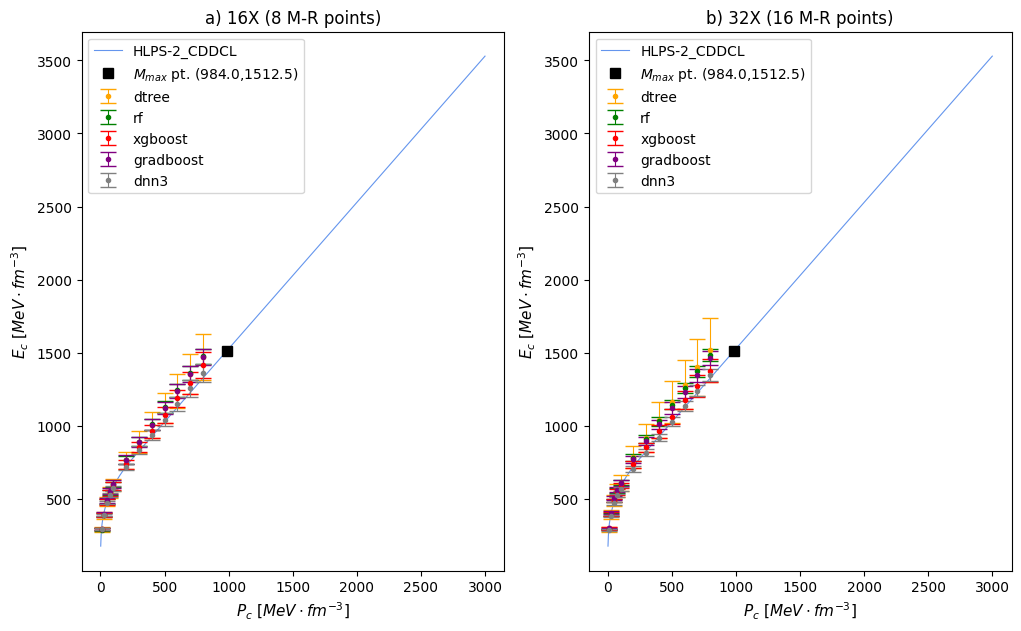

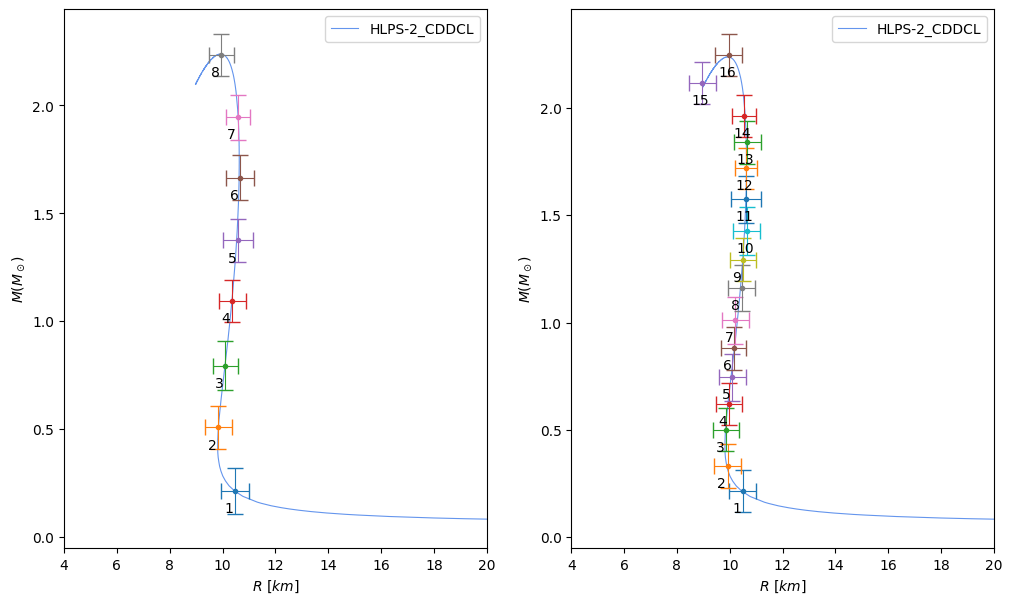

In [5]:
fig_HLPS_2_CDDCL_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_HLPS_2_CDDCL_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_polyNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],poly_EOS="HLPS-2_CDDCL",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_polyNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],poly_EOS="HLPS-2_CDDCL",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

## **2.2 HLPS-3_CACDL results**

In [ ]:
fig_HLPS_3_CACDL_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_HLPS_3_CACDL_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_polyNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],poly_EOS="HLPS-3_CACDL",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_polyNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],poly_EOS="HLPS-3_CACDL",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

> HLPS-3_CACDL


# 3. Predicting polytropic EOSs (unused)

## **3.1 HLPS-2_AADDL results**

> HLPS-2_AADDL

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01198564532795108
rf:  0.00812706112724841
xgboost:  0.003982799304408946
gradboost:  0.007179761660532057
dnn3:  0.0034162659746244488
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0034162659746244488
---------------------------------------------------------------------


> HLPS-2_AADDL

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.014605683010180575
rf:  0.008300756356627083
xgboost:  0.0033722695963931426
gradboost:  0.0068154722815515515
dnn3:  0.003127537133790102
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.003127537133790102
---------------------------------------------------------------------




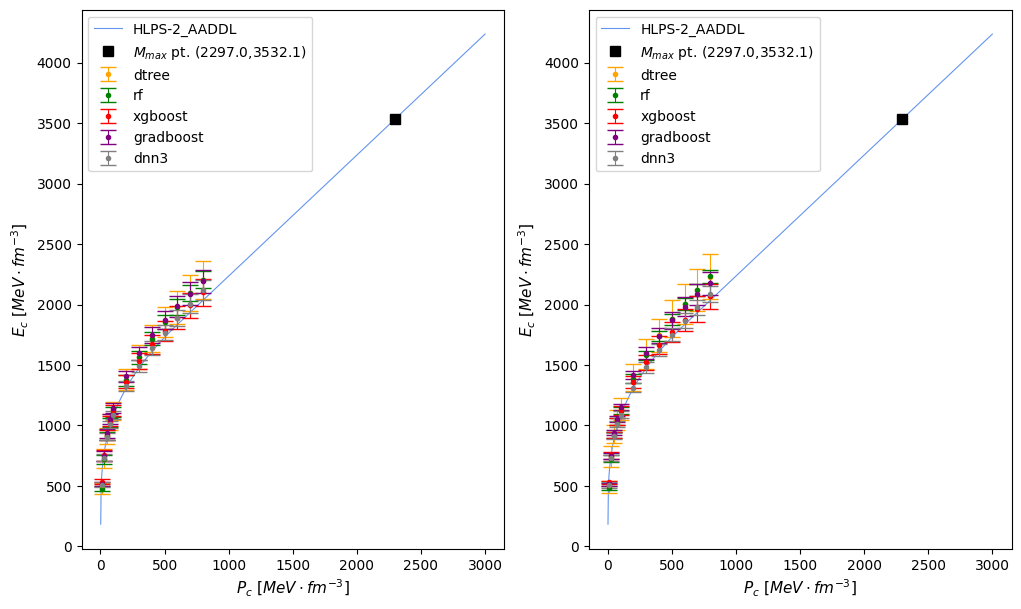

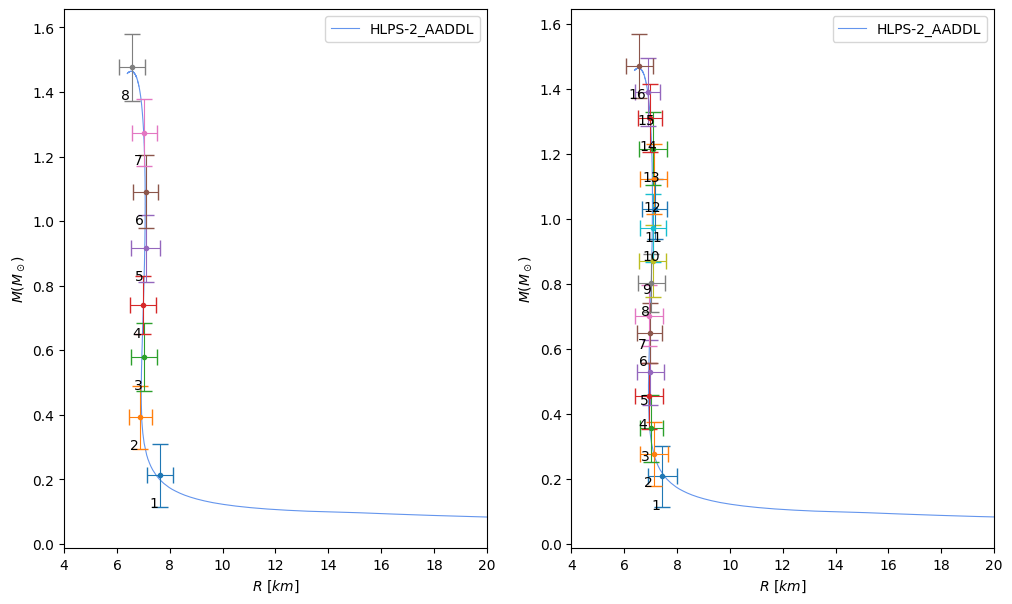

In [12]:
fig_HLPS_2_AADDL_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_HLPS_2_AADDL_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_polyNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],poly_EOS="HLPS-2_AADDL",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_polyNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],poly_EOS="HLPS-2_AADDL",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

## **3.2 HLPS-2_DDCBL results**

> HLPS-2_DDCBL

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.008882661593712786
rf:  0.0033725733546043856
xgboost:  0.0029202356869950344
gradboost:  0.004227879826641754
dnn3:  0.003269304296864646
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0029202356869950344
---------------------------------------------------------------------


> HLPS-2_DDCBL

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01179945106664363
rf:  0.0035242553361690184
xgboost:  0.0020402716924625046
gradboost:  0.0031691048788896805
dnn3:  0.0025608401059730745
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0020402716924625046
---------------------------------------------------------------------




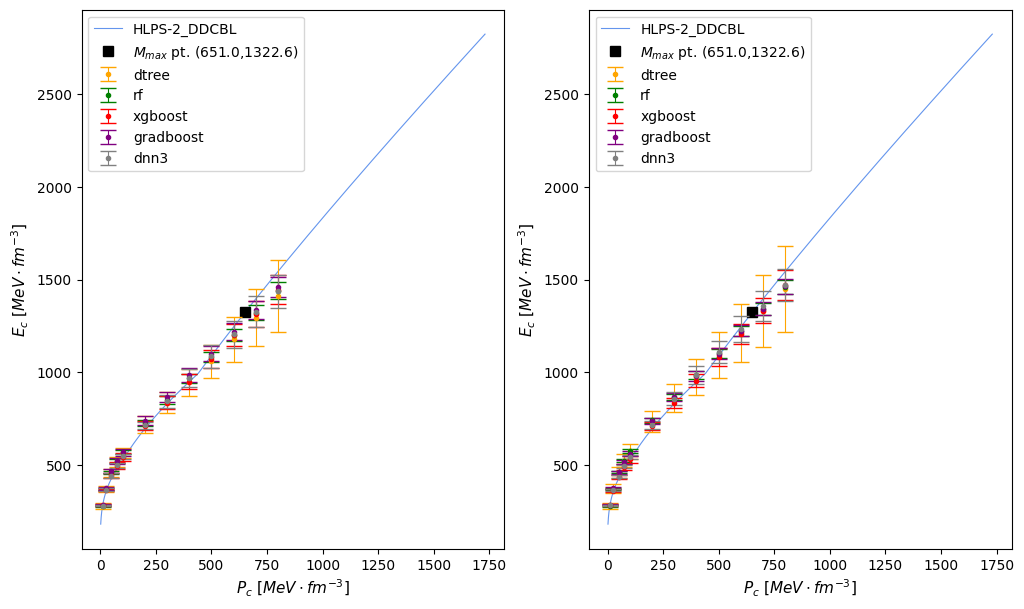

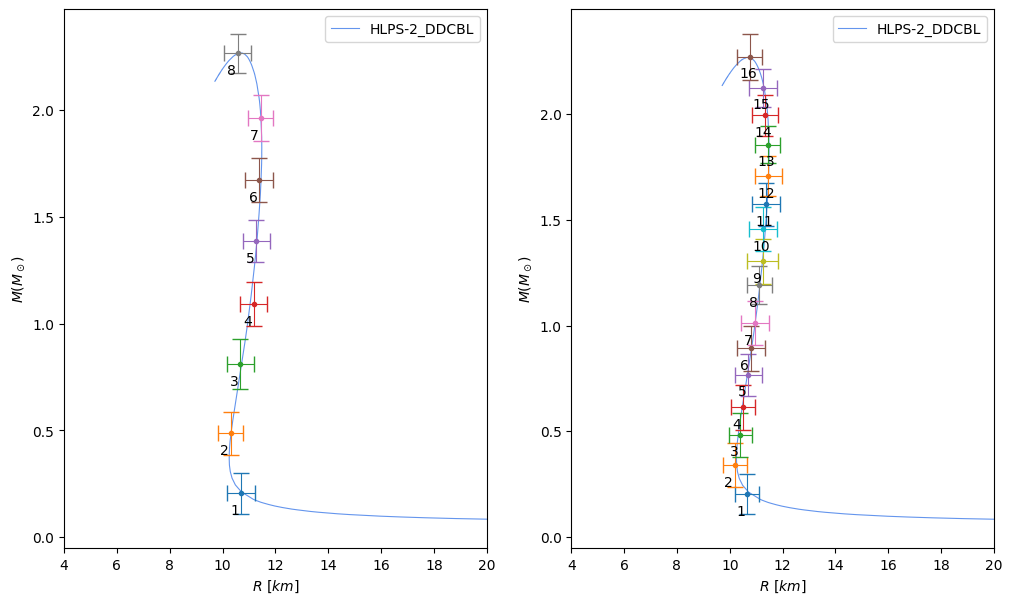

In [6]:
fig_HLPS_2_DDCBL_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_HLPS_2_DDCBL_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_polyNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],poly_EOS="HLPS-2_DDCBL",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_polyNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],poly_EOS="HLPS-2_DDCBL",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

## **3.3 HLPS-3_BBDCL results**

> HLPS-3_BBDCL

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.010820926572617226
rf:  0.003991022791125715
xgboost:  0.0035273345089459215
gradboost:  0.003929535795670812
dnn3:  0.0026866068708526
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0026866068708526
---------------------------------------------------------------------


> HLPS-3_BBDCL

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.014422552063907246
rf:  0.0033669266299932786
xgboost:  0.0024089050233407545
gradboost:  0.003218713394474829
dnn3:  0.0024096799847668528
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0024089050233407545
---------------------------------------------------------------------




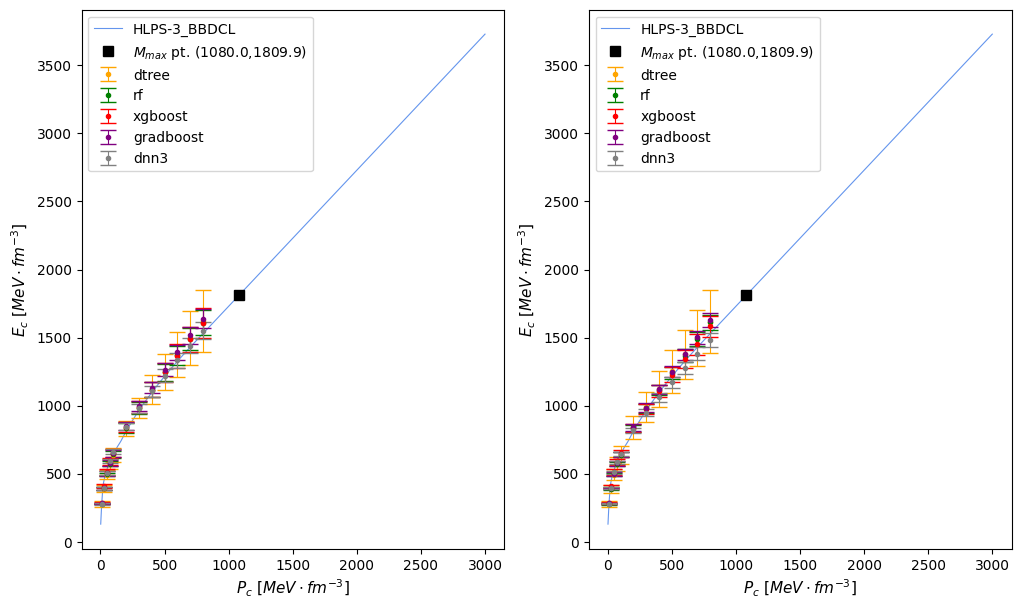

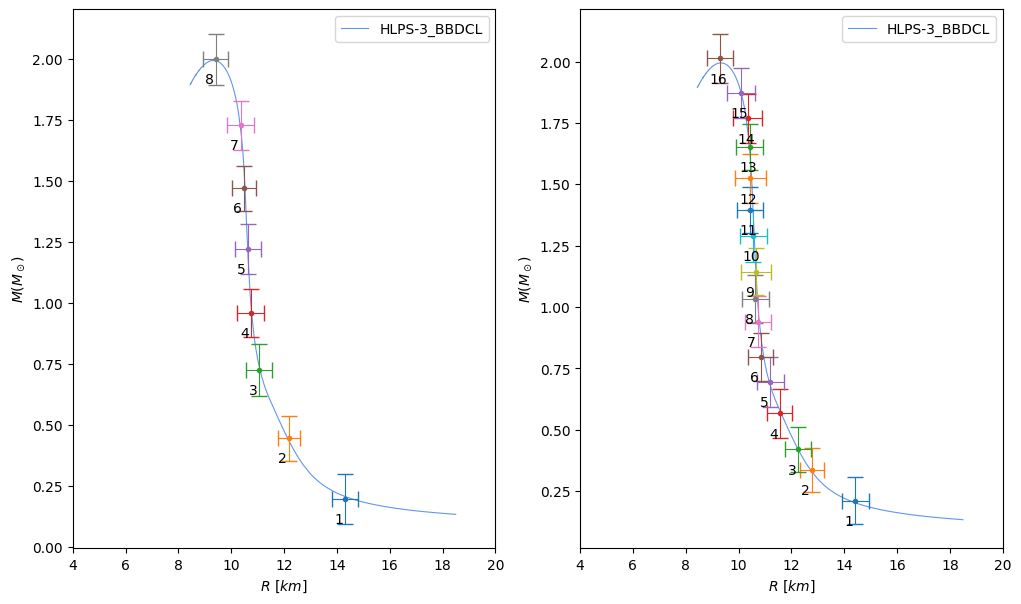

In [7]:
fig_HLPS_3_BBDCL_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_HLPS_3_BBDCL_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_polyNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],poly_EOS="HLPS-3_BBDCL",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_polyNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],poly_EOS="HLPS-3_BBDCL",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

## **3.4 HLPS-3_CDACL results**

> HLPS-3_CDACL

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.02468716616781136
rf:  0.01096231934251638
xgboost:  0.00801767849743334
gradboost:  0.016553264054281484
dnn3:  0.0070102320380865625
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0070102320380865625
---------------------------------------------------------------------


> HLPS-3_CDACL

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.029004368676874382
rf:  0.017218554144625777
xgboost:  0.013288130317318715
gradboost:  0.017638636404273426
dnn3:  0.01265881538559102
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.01265881538559102
---------------------------------------------------------------------




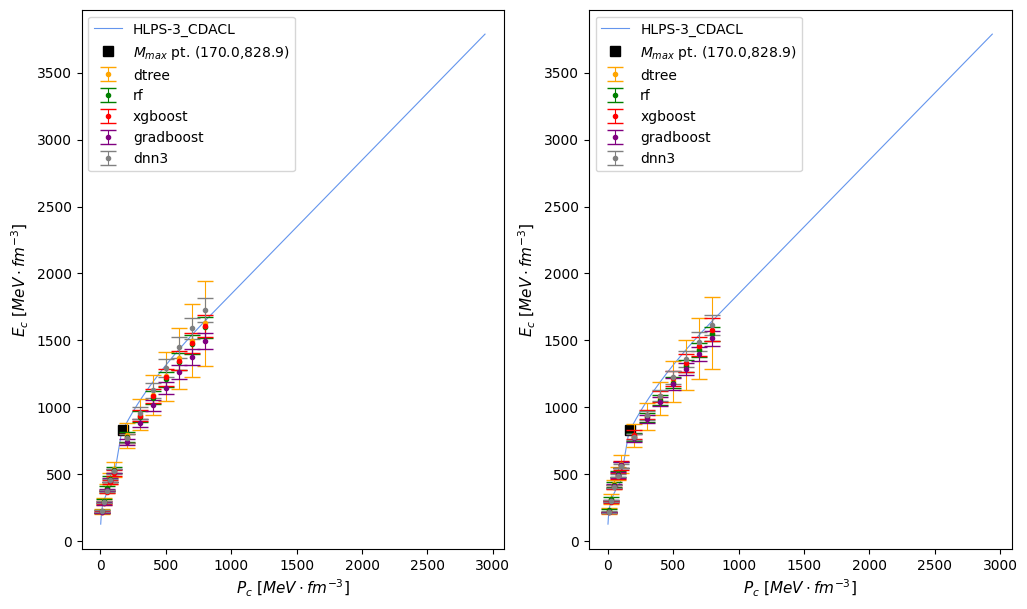

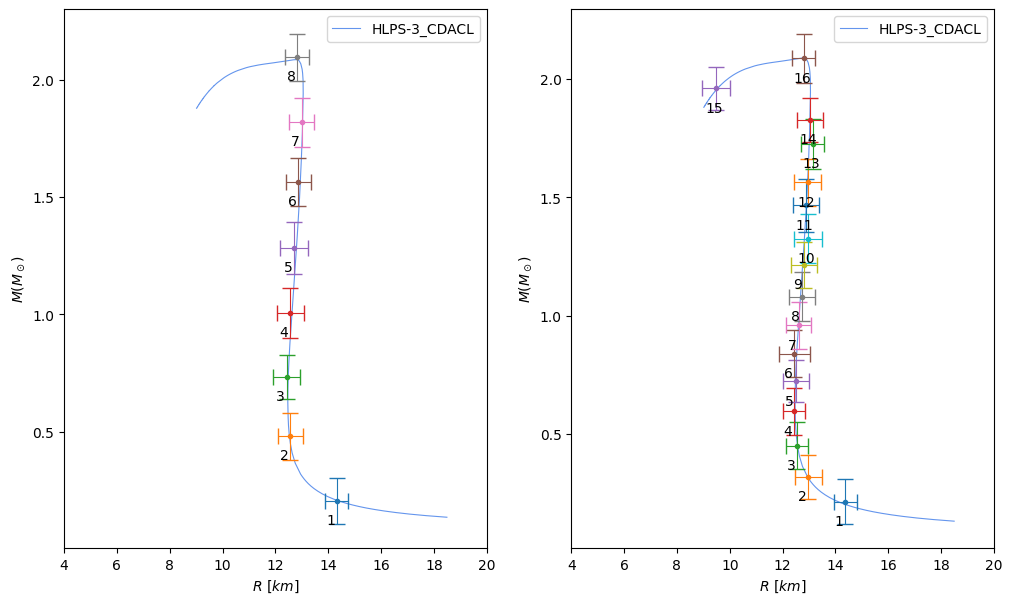

In [8]:
fig_HLPS_3_CDACL_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_HLPS_3_CDACL_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_polyNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],poly_EOS="HLPS-3_CDACL",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_polyNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],poly_EOS="HLPS-3_CDACL",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

# 4. Predicting main EOSs

## **4.1 APR-1 results**

> APR-1

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.007268913199950652
rf:  0.0042052834722524106
xgboost:  0.004322615372678835
gradboost:  0.005157342052720397
dnn3:  0.0021847307037028037
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0021847307037028037
---------------------------------------------------------------------


> APR-1

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.015682399480994164
rf:  0.005407762311996037
xgboost:  0.005596480102306188
gradboost:  0.005101789613546522
dnn3:  0.0018847236406347358
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0018847236406347358
---------------------------------------------------------------------




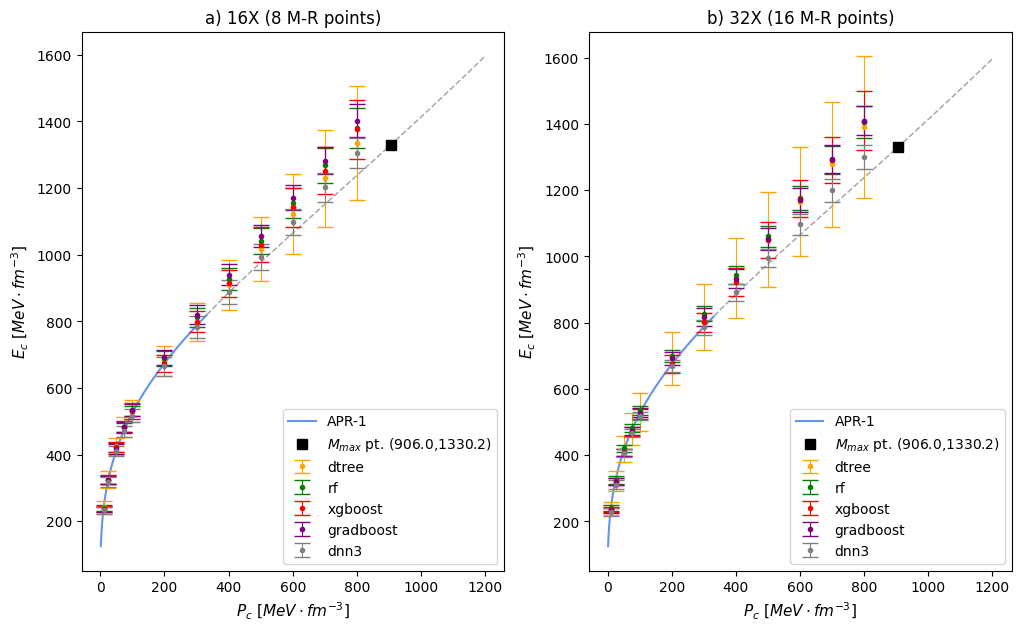

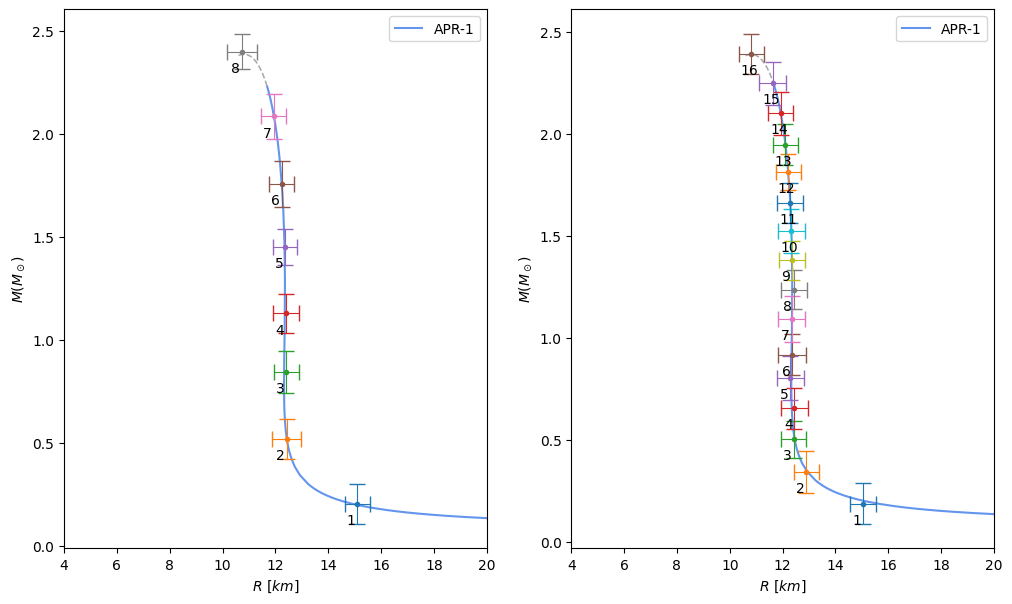

In [8]:
fig_APR1_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_APR1_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="APR-1",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="APR-1",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_APR1_EOS.savefig("APR-1_EOS_predict.pdf",dpi=300)
fig_APR1_MR.savefig("APR-1_MR_predict.pdf",dpi=300)

## **4.2 BGP results**

> BGP

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.007144947638517467
rf:  0.0028622355431870057
xgboost:  0.002872512842626637
gradboost:  0.0019954441271359106
dnn3:  0.0036345516839754537
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.0019954441271359106
---------------------------------------------------------------------


> BGP

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.011791844812644706
rf:  0.002543195280984688
xgboost:  0.003044373058025806
gradboost:  0.0027012065909447973
dnn3:  0.002246096519509951
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.002246096519509951
---------------------------------------------------------------------




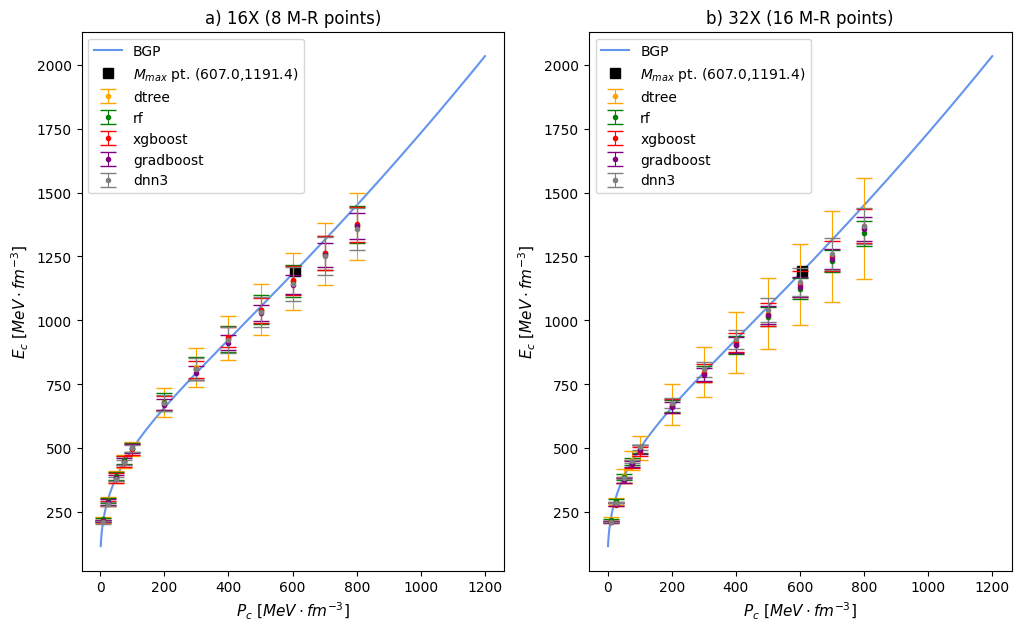

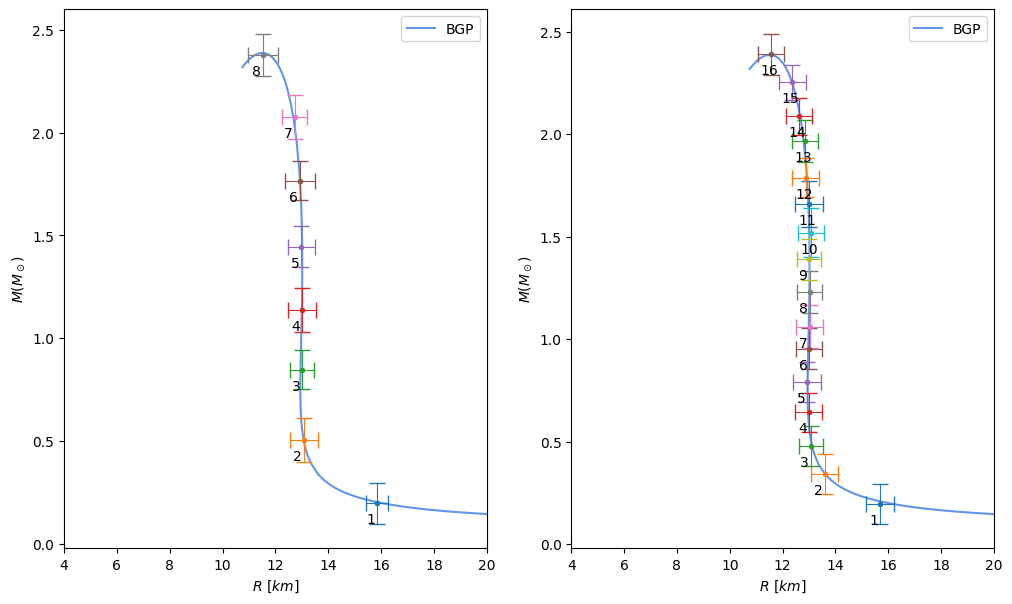

In [9]:
fig_BGP_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_BGP_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="BGP",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="BGP",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_BGP_EOS.savefig("BGP_EOS_predict.pdf",dpi=300)

## **4.3 BL-1 results**

> BL-1

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.016567810952617557
rf:  0.001949175538621539
xgboost:  0.0024711077964568065
gradboost:  0.0012126782948054353
dnn3:  0.0038583668452130786
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.0012126782948054353
---------------------------------------------------------------------


> BL-1

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.014587965654550108
rf:  0.0012640760667711399
xgboost:  0.0026423051551331222
gradboost:  0.0013005391536126713
dnn3:  0.00268335524597907
---------------------------------------------------------------------
Best model:
rf
Best model MSLE:
0.0012640760667711399
---------------------------------------------------------------------




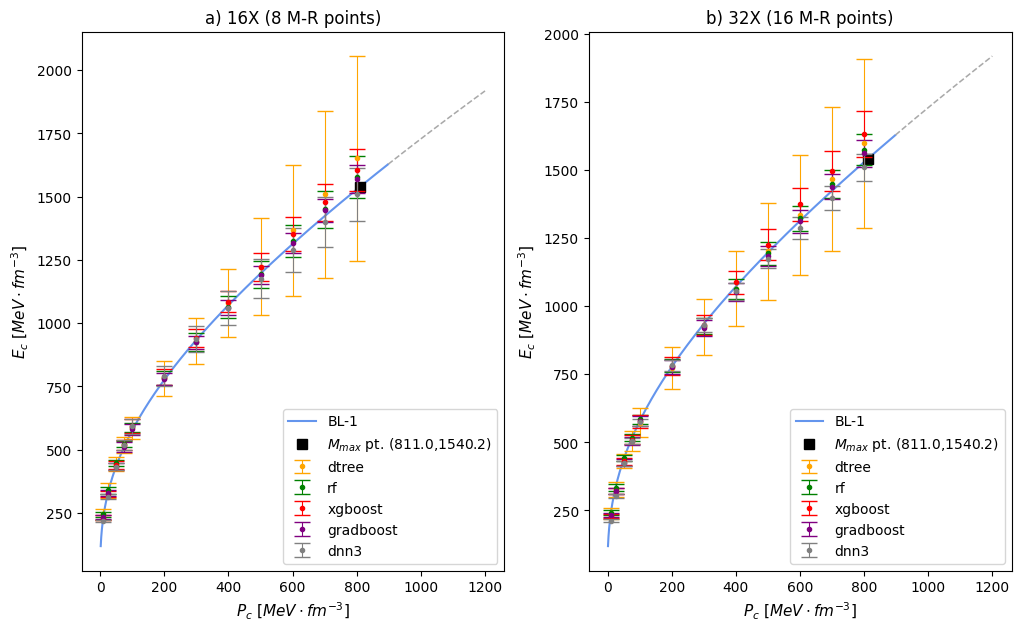

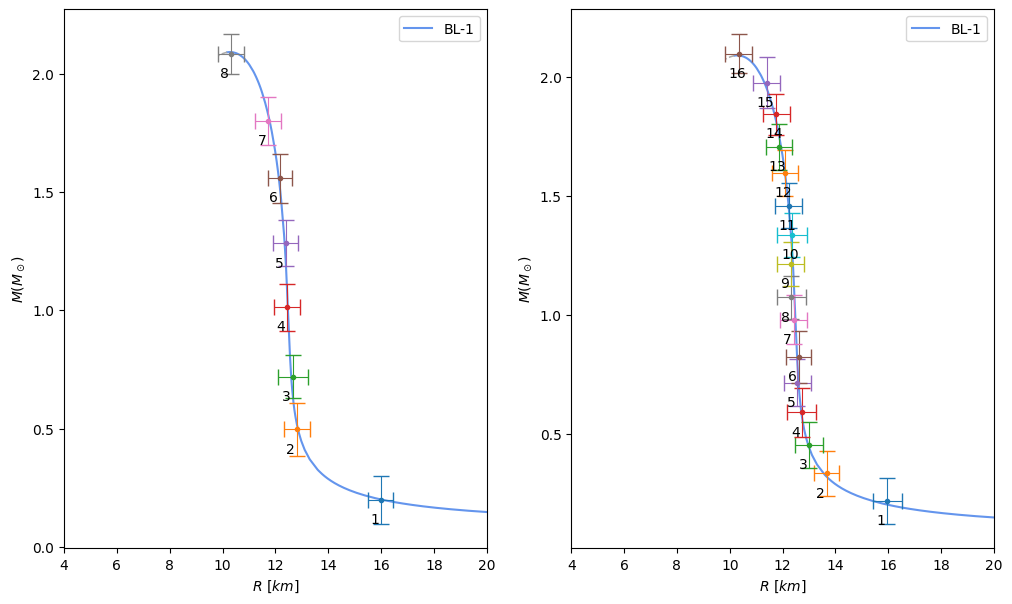

In [10]:
fig_BL1_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_BL1_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="BL-1",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="BL-1",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_BL1_EOS.savefig("BL-1_EOS_predict.pdf",dpi=300)

## **4.4 BL-2 results**

> BL-2

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01219832838550757
rf:  0.0028714334372899244
xgboost:  0.002538650621999906
gradboost:  0.001974995421712258
dnn3:  0.003289460598166543
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.001974995421712258
---------------------------------------------------------------------


> BL-2

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01662250174295941
rf:  0.0014953508537769147
xgboost:  0.0020239904744302774
gradboost:  0.0016146532917615834
dnn3:  0.003223224405506167
---------------------------------------------------------------------
Best model:
rf
Best model MSLE:
0.0014953508537769147
---------------------------------------------------------------------




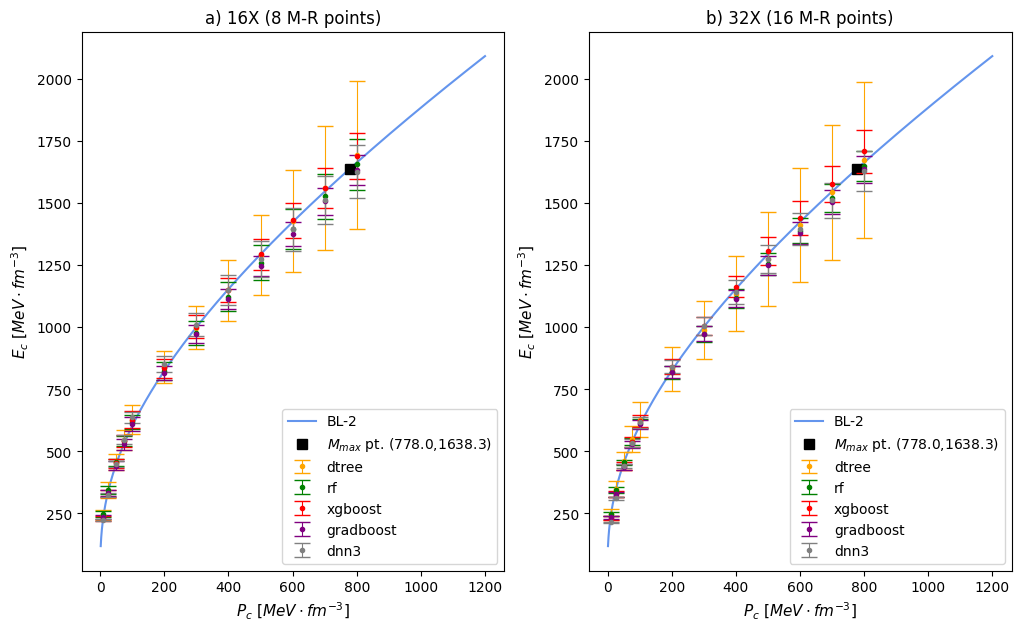

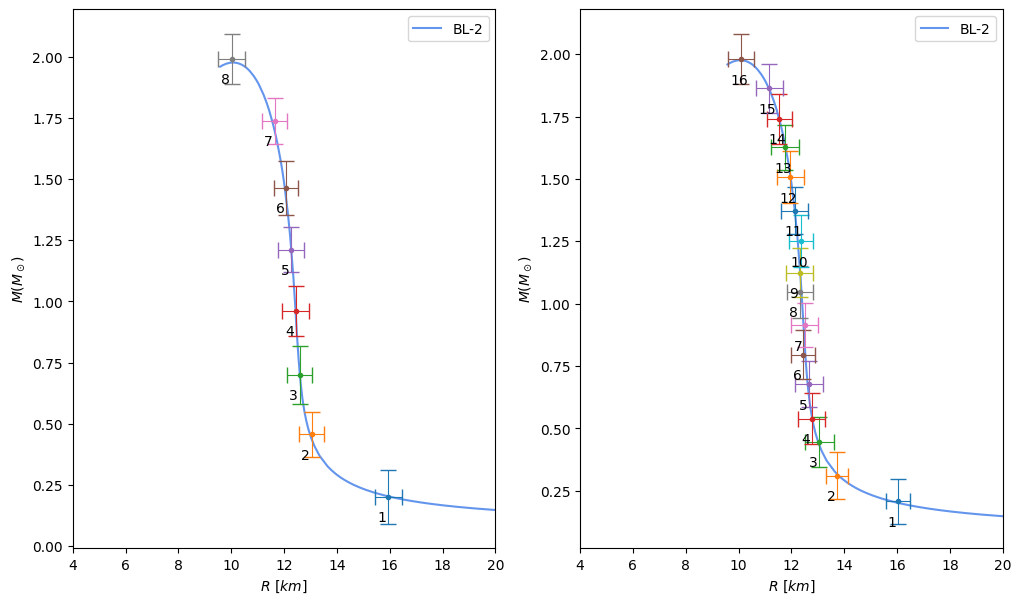

In [11]:
fig_BL2_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_BL2_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="BL-2",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="BL-2",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_BL2_EOS.savefig("BL-2_EOS_predict.pdf",dpi=300)

## **4.5 DH results**

> DH

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.02016830013683096
rf:  0.00485761869200788
xgboost:  0.003969398545078383
gradboost:  0.0027519749865636696
dnn3:  0.004417983012848616
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.0027519749865636696
---------------------------------------------------------------------


> DH

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.020183419004540414
rf:  0.003686668091635433
xgboost:  0.003819989106699386
gradboost:  0.0024870566265940424
dnn3:  0.0017381035320248707
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0017381035320248707
---------------------------------------------------------------------




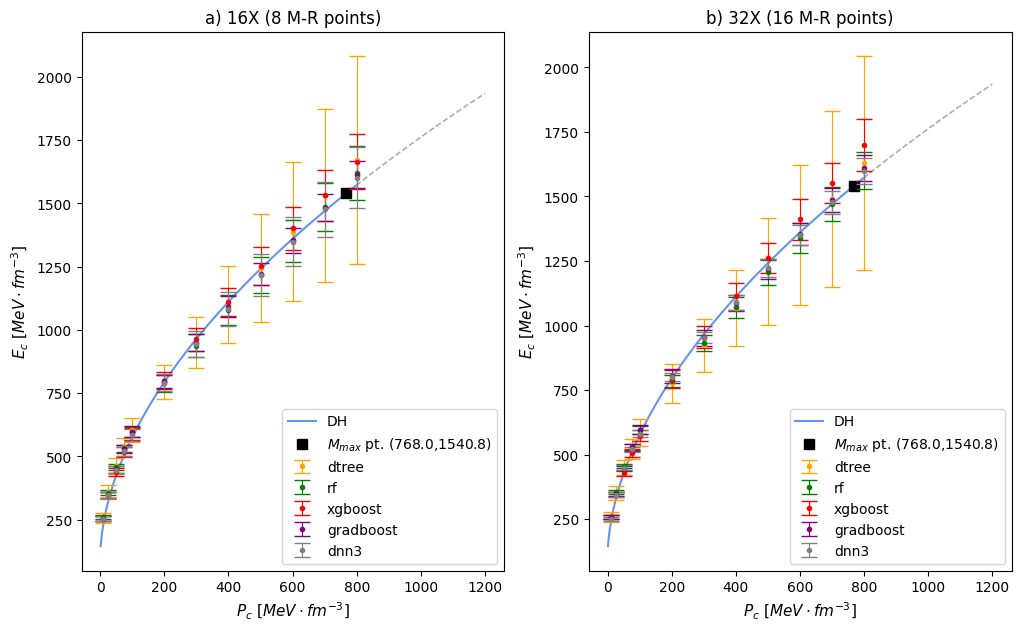

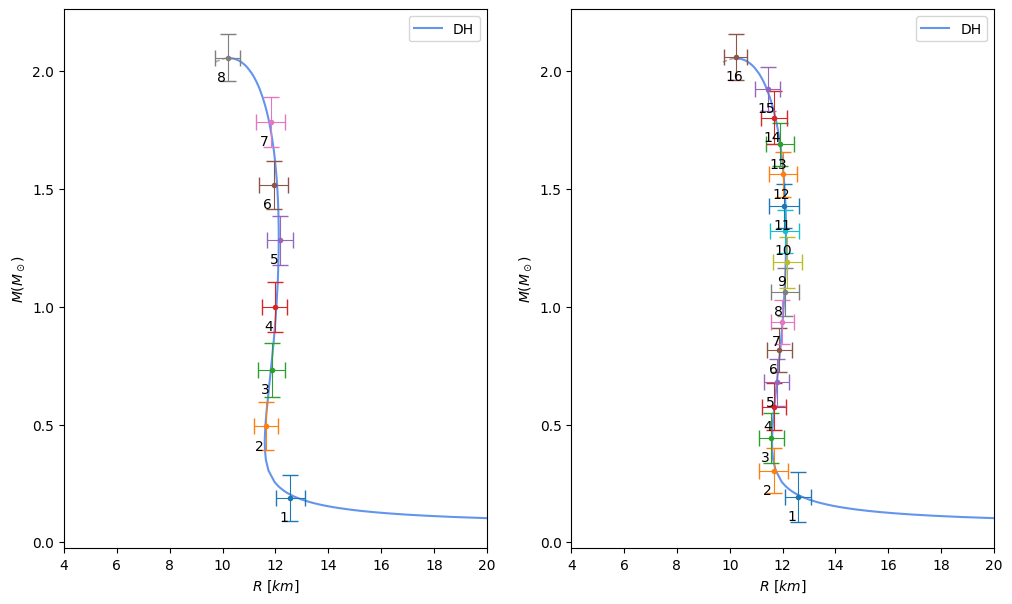

In [12]:
fig_DH_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_DH_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="DH",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="DH",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_DH_EOS.savefig("DH_EOS_predict.pdf",dpi=300)

## **4.6 HHJ-1 results**

> HHJ-1

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.016004734813967827
rf:  0.004380065940456891
xgboost:  0.002672116007502239
gradboost:  0.004369070702710656
dnn3:  0.0028788972154484616
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.002672116007502239
---------------------------------------------------------------------


> HHJ-1

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.018865078701306808
rf:  0.004719913983112004
xgboost:  0.0022598207294563582
gradboost:  0.00450810183615439
dnn3:  0.004556664417089673
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0022598207294563582
---------------------------------------------------------------------




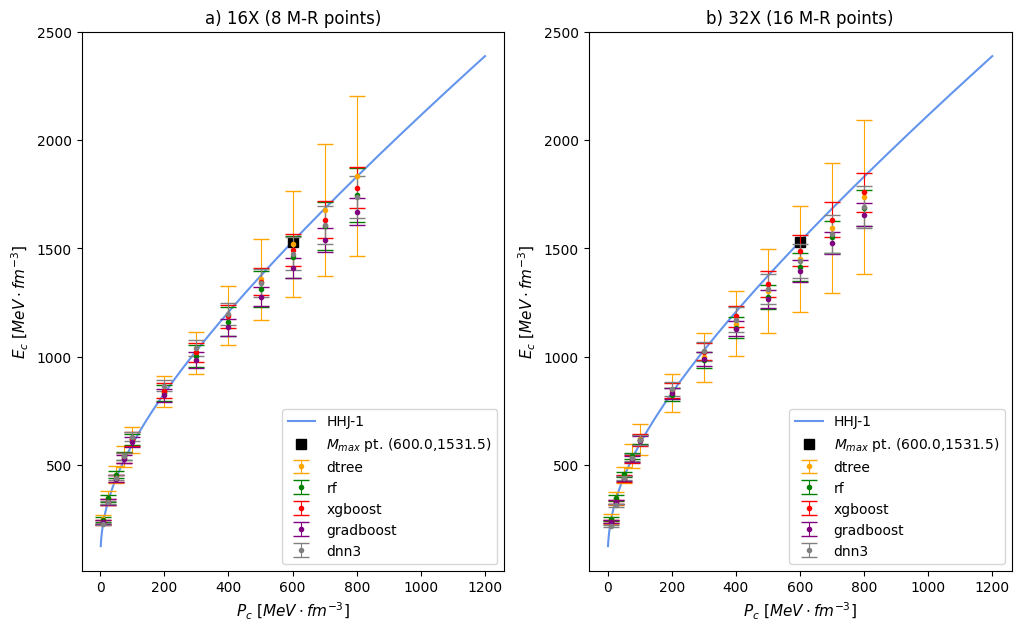

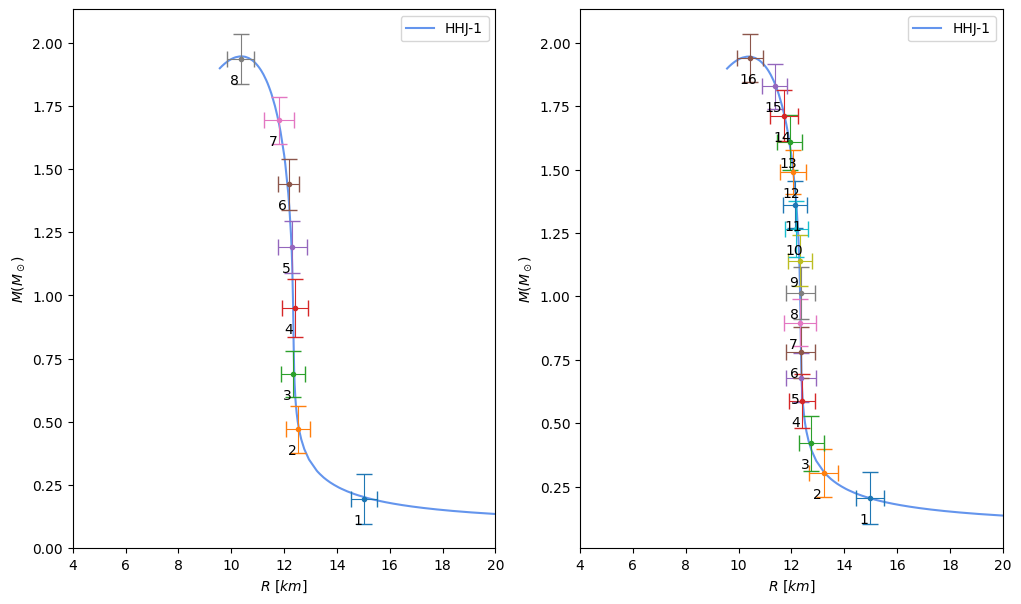

In [13]:
fig_HHJ1_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_HHJ1_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="HHJ-1",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="HHJ-1",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_HHJ1_EOS.savefig("HHJ-1_EOS_predict.pdf",dpi=300)

## **4.7 HHJ-2 results**

> HHJ-2

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01923924311202539
rf:  0.002664272987906243
xgboost:  0.0024238176339061684
gradboost:  0.0027056428158071695
dnn3:  0.0047365770827641675
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0024238176339061684
---------------------------------------------------------------------


> HHJ-2

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.017013257248296162
rf:  0.0027211555128526105
xgboost:  0.0017534872006408828
gradboost:  0.0020177799252913413
dnn3:  0.0029985203115321982
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0017534872006408828
---------------------------------------------------------------------




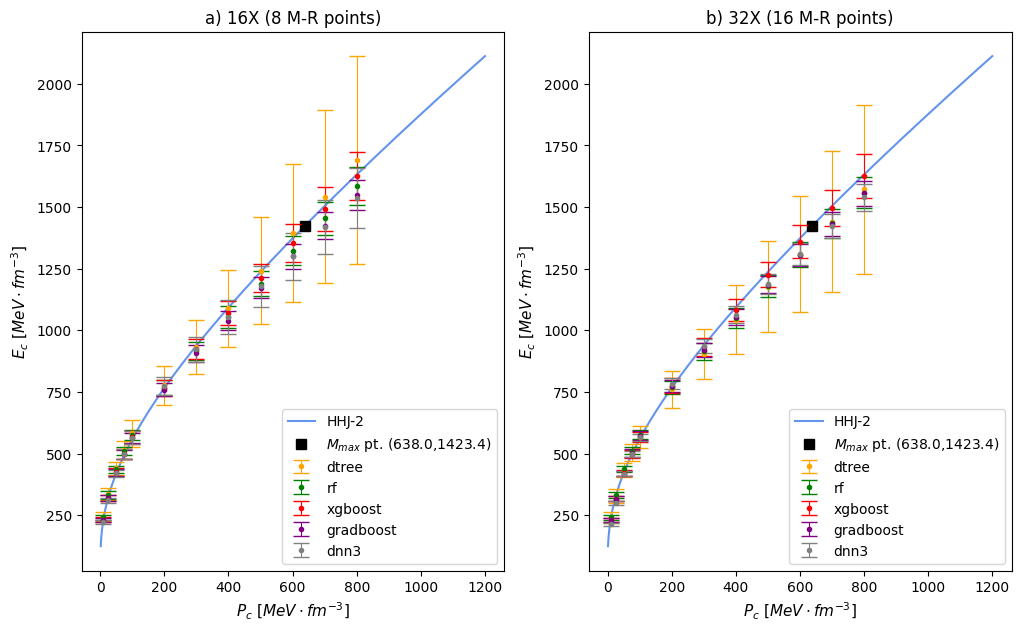

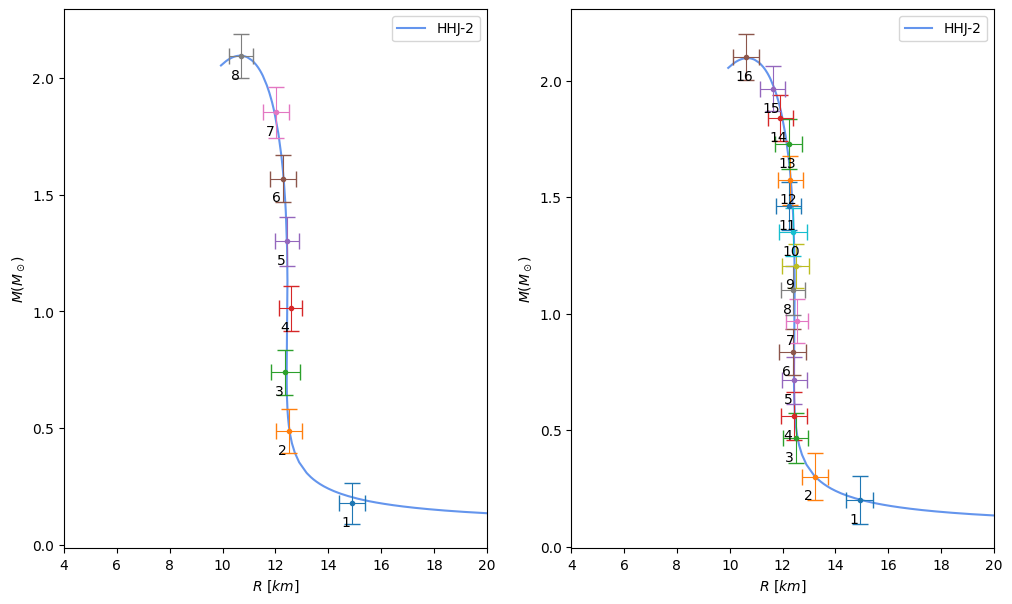

In [14]:
fig_HHJ2_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_HHJ2_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="HHJ-2",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="HHJ-2",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_HHJ2_EOS.savefig("HHJ-2_EOS_predict.pdf",dpi=300)

## **4.8 HLPS-2 results**

> HLPS-2

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.017459721120127378
rf:  0.0073971768196356156
xgboost:  0.005211618780744882
gradboost:  0.007261019009636949
dnn3:  0.002567328222892297
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.002567328222892297
---------------------------------------------------------------------


> HLPS-2

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01617902098886244
rf:  0.008816282883863361
xgboost:  0.0046650599314219015
gradboost:  0.0071113790689870315
dnn3:  0.003443939142144392
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.003443939142144392
---------------------------------------------------------------------




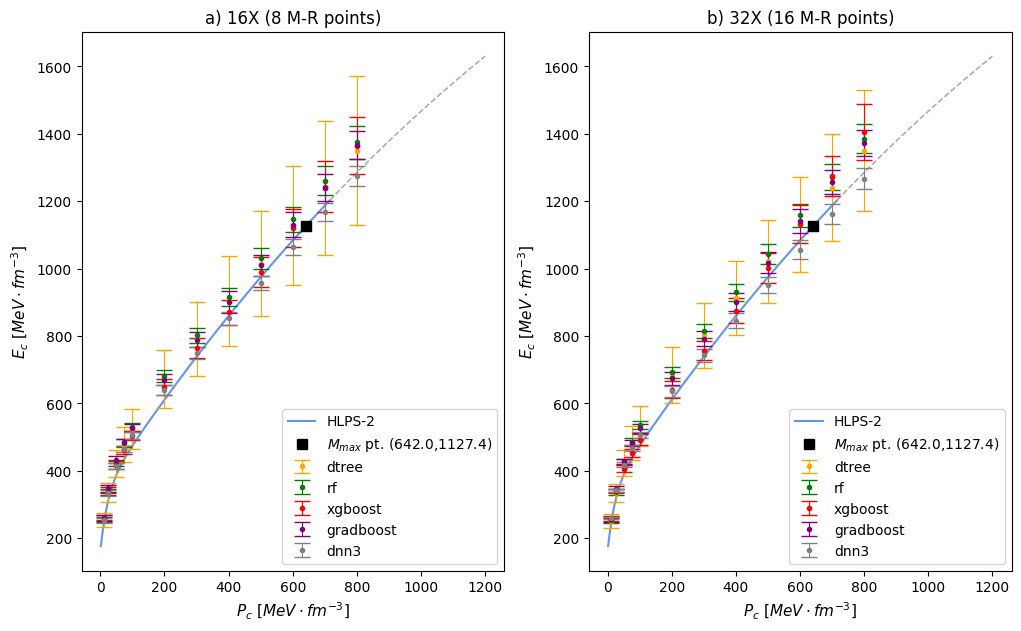

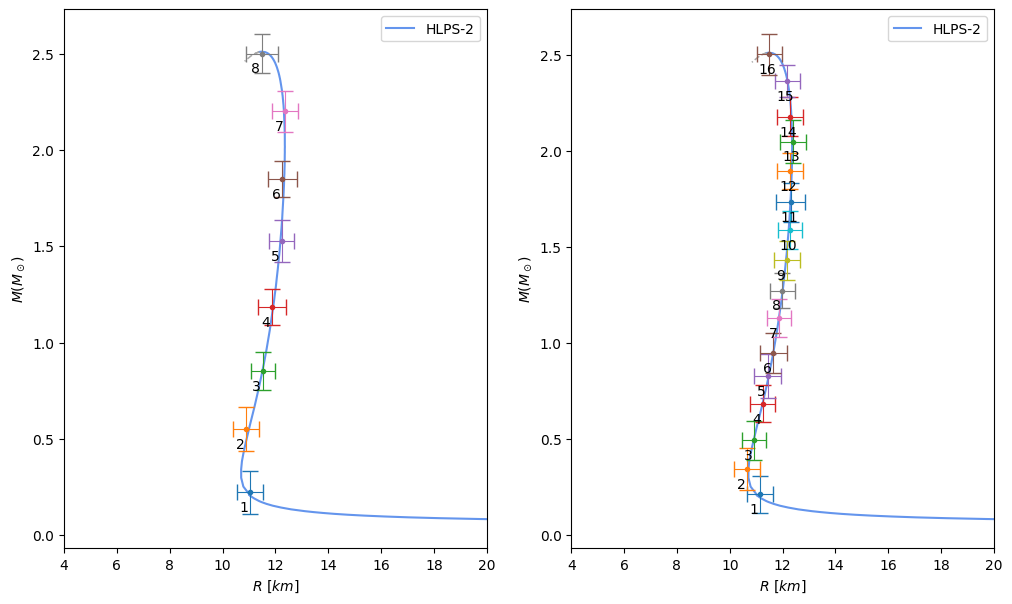

In [15]:
fig_HLPS2_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_HLPS2_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="HLPS-2",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="HLPS-2",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_HLPS2_EOS.savefig("HLPS-2_EOS_predict.pdf",dpi=300)

## **4.9 HLPS-3 results**

> HLPS-3

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.00953074235455689
rf:  0.010033469389119828
xgboost:  0.007544577833251083
gradboost:  0.012050235562530903
dnn3:  0.005468611164816946
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.005468611164816946
---------------------------------------------------------------------


> HLPS-3

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.014604690581082519
rf:  0.014183046493017206
xgboost:  0.008130799311890086
gradboost:  0.011729564666140191
dnn3:  0.00567959292826313
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.00567959292826313
---------------------------------------------------------------------




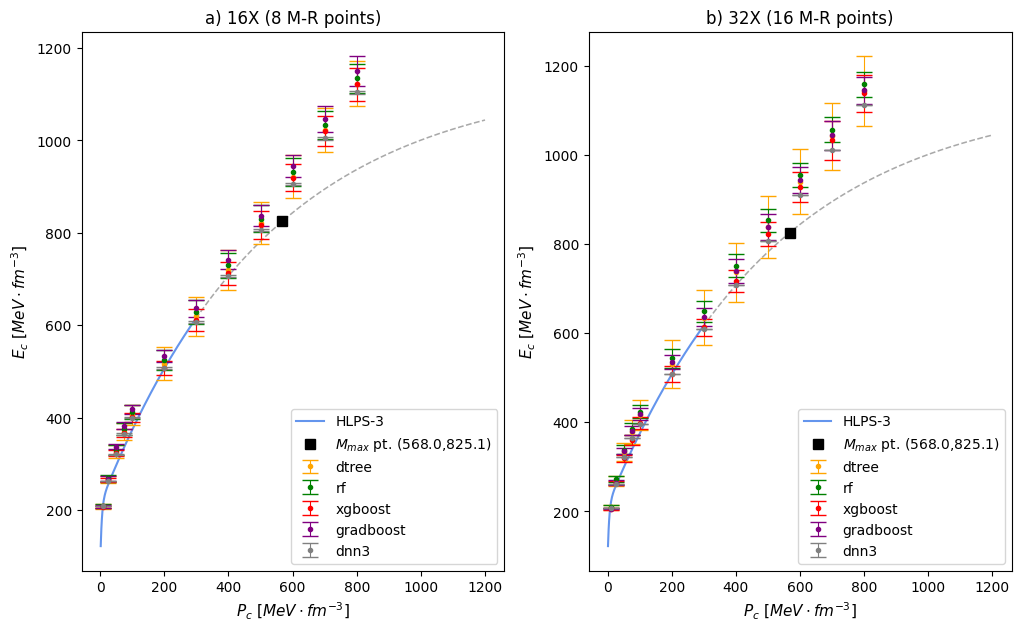

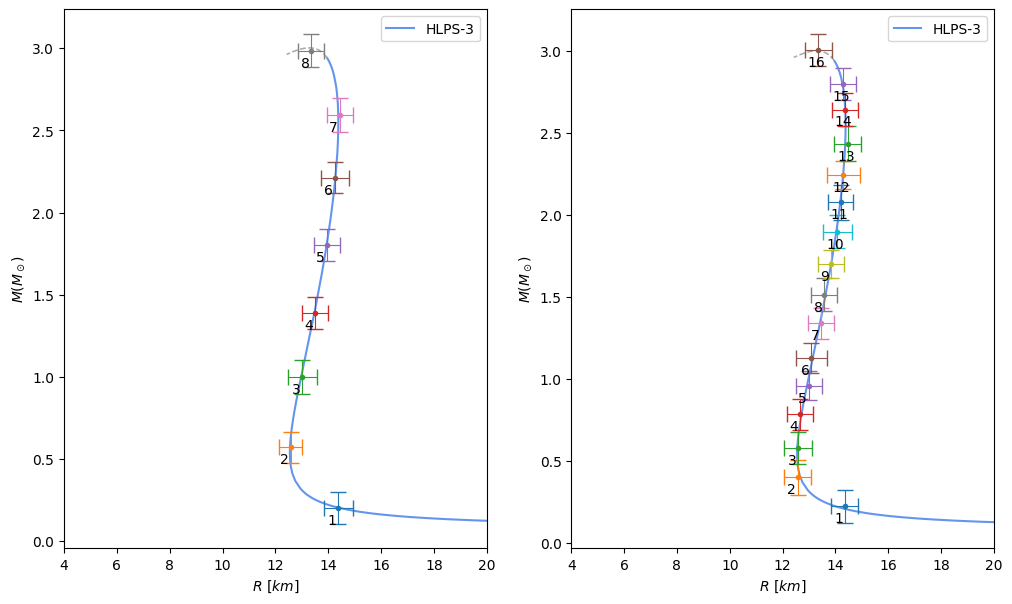

In [16]:
fig_HLPS3_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_HLPS3_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="HLPS-3",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="HLPS-3",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_HLPS3_EOS.savefig("HLPS-3_EOS_predict.pdf",dpi=300)

## **4.10 MDI-1 results**

> MDI-1

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.014489162370038477
rf:  0.004444482014591219
xgboost:  0.004012071034842488
gradboost:  0.005691357762397581
dnn3:  0.006377549081178842
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.004012071034842488
---------------------------------------------------------------------


> MDI-1

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.012565104103597007
rf:  0.0037235023105791167
xgboost:  0.002807691936764247
gradboost:  0.005775718959486857
dnn3:  0.003613423019413605
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.002807691936764247
---------------------------------------------------------------------




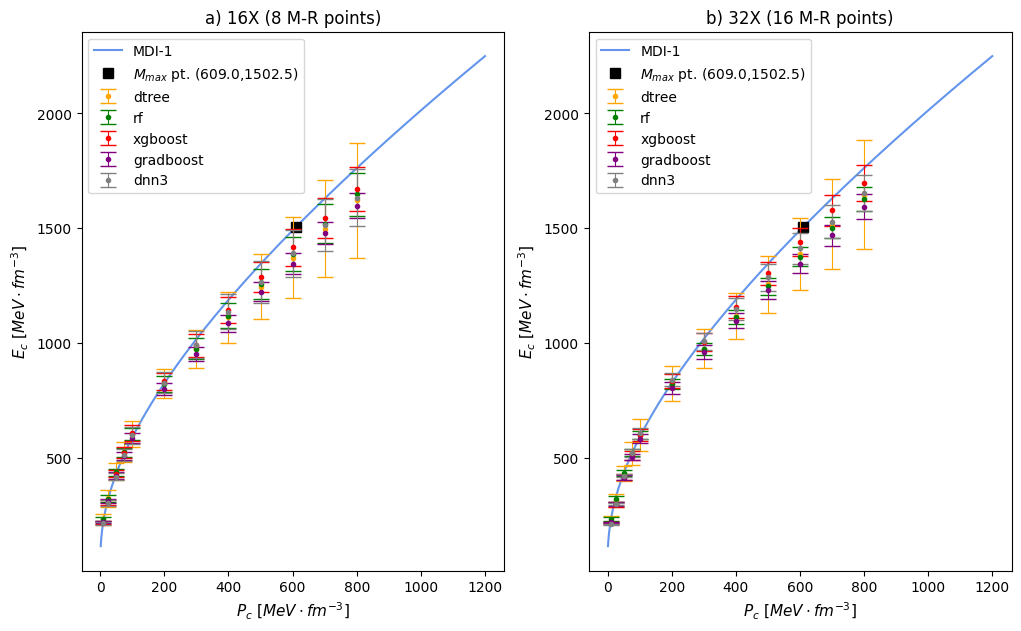

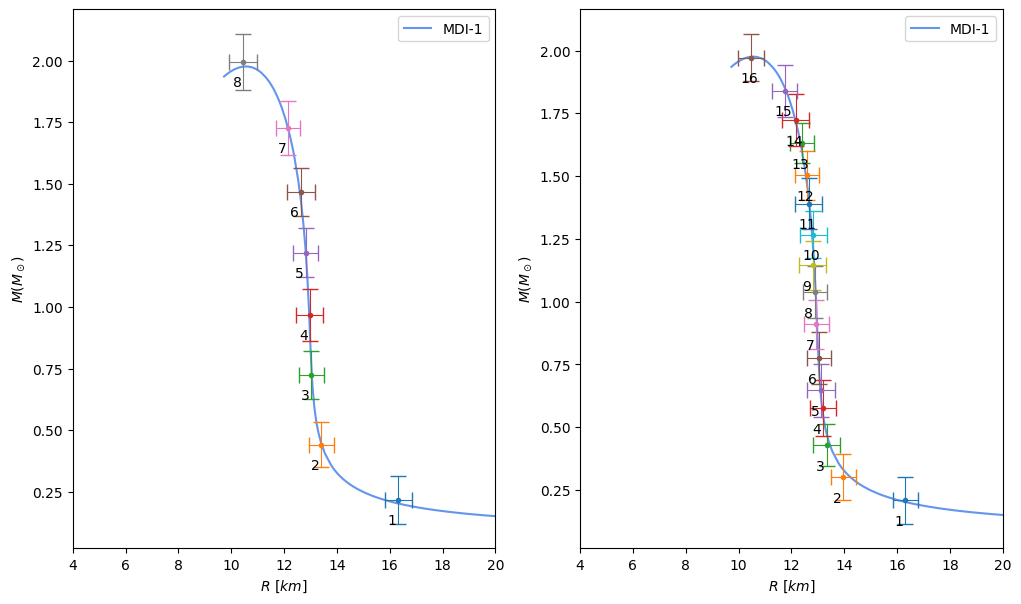

In [17]:
fig_MDI1_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MDI1_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="MDI-1",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="MDI-1",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MDI1_EOS.savefig("MDI-1_EOS_predict.pdf",dpi=300)

## **4.11 MDI-2 results**

> MDI-2

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.013002248253303277
rf:  0.004200454806403808
xgboost:  0.004024198074392
gradboost:  0.007804437203787438
dnn3:  0.008160178220608418
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.004024198074392
---------------------------------------------------------------------


> MDI-2

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.016629786280544952
rf:  0.005368278497412646
xgboost:  0.0038936403528825256
gradboost:  0.007950285770813647
dnn3:  0.005531871412596453
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0038936403528825256
---------------------------------------------------------------------




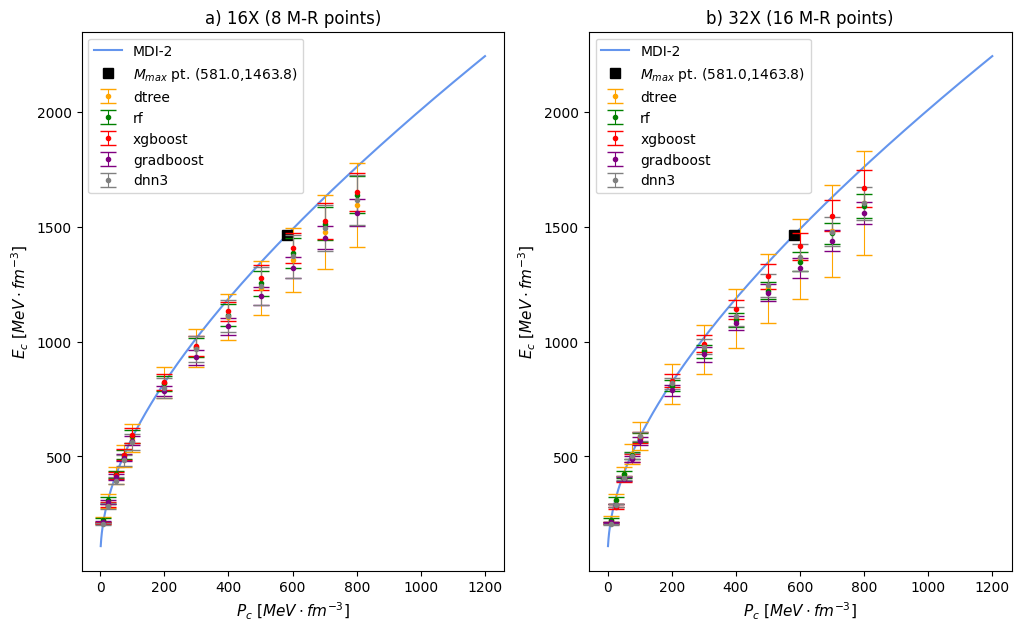

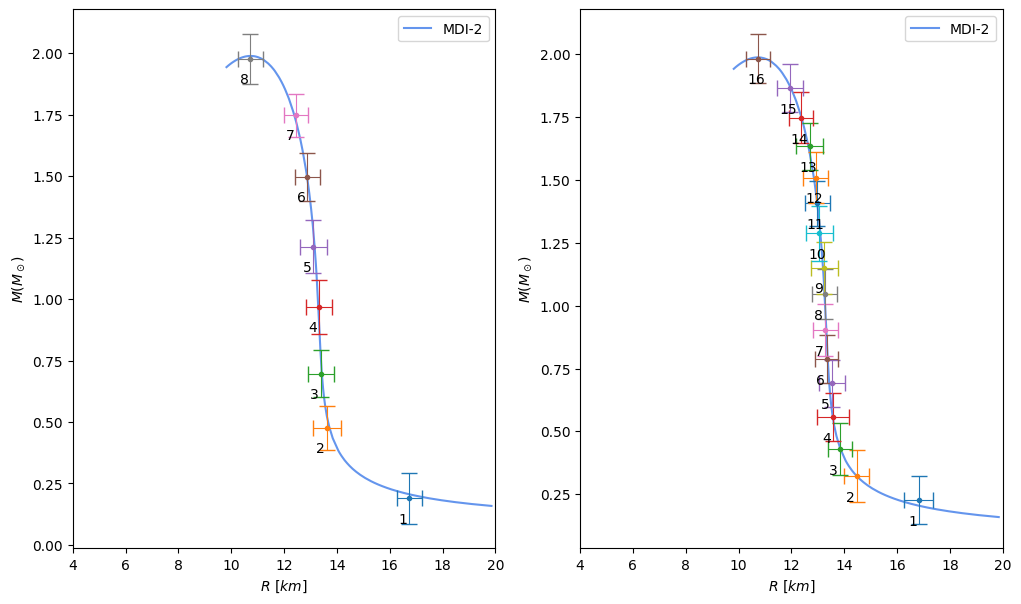

In [18]:
fig_MDI2_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MDI2_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="MDI-2",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="MDI-2",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MDI2_EOS.savefig("MDI-2_EOS_predict.pdf",dpi=300)

## **4.12 MDI-3 results**

> MDI-3

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.011038726602698138
rf:  0.004865791054811432
xgboost:  0.004308517406226987
gradboost:  0.009230598473300789
dnn3:  0.012957283415145834
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.004308517406226987
---------------------------------------------------------------------


> MDI-3

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.015382029799275061
rf:  0.007435813034879217
xgboost:  0.005300352564477864
gradboost:  0.009941812738912642
dnn3:  0.008593167718938598
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.005300352564477864
---------------------------------------------------------------------




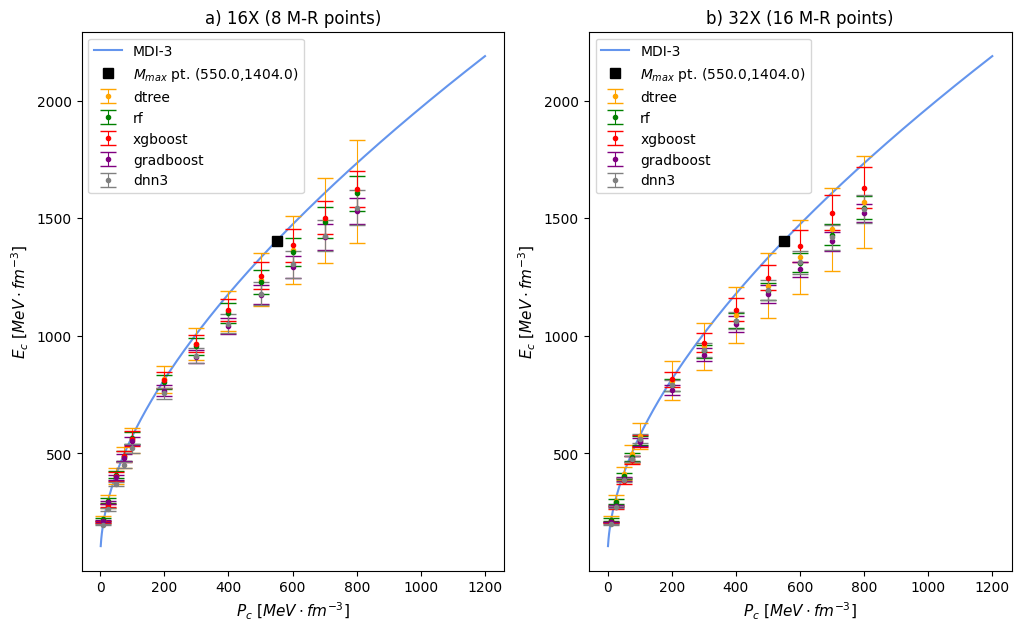

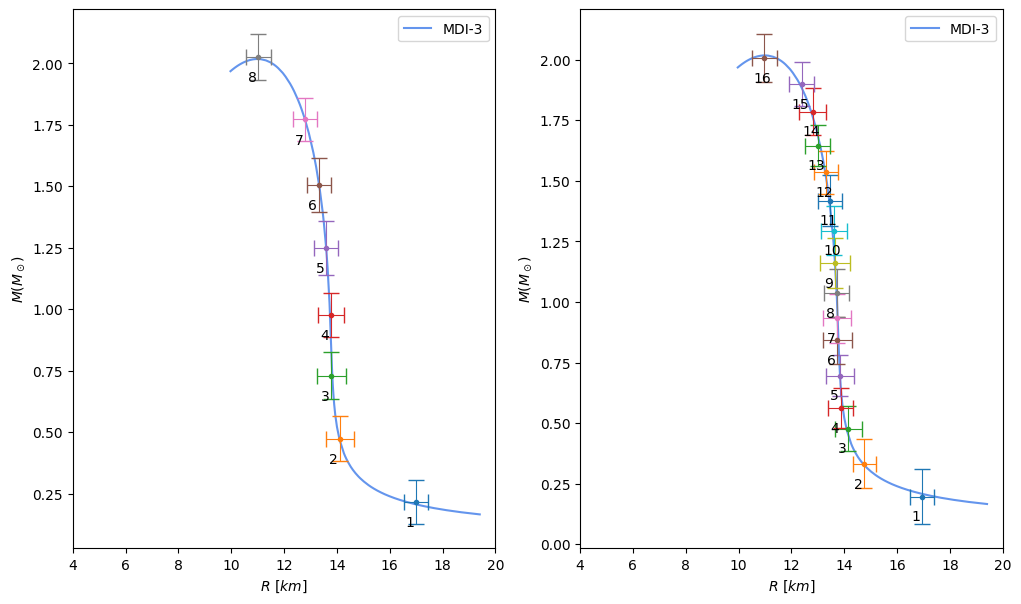

In [19]:
fig_MDI3_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MDI3_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="MDI-3",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="MDI-3",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MDI3_EOS.savefig("MDI-3_EOS_predict.pdf",dpi=300)

## **4.13 MDI-4 results**

> MDI-4

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.011971722917952734
rf:  0.0055637667363321736
xgboost:  0.0041007079032379014
gradboost:  0.009813350941317148
dnn3:  0.013132257864764322
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0041007079032379014
---------------------------------------------------------------------


> MDI-4

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01174535552925944
rf:  0.010082494614304584
xgboost:  0.00682434413135146
gradboost:  0.012425284571483388
dnn3:  0.010692668050700653
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.00682434413135146
---------------------------------------------------------------------




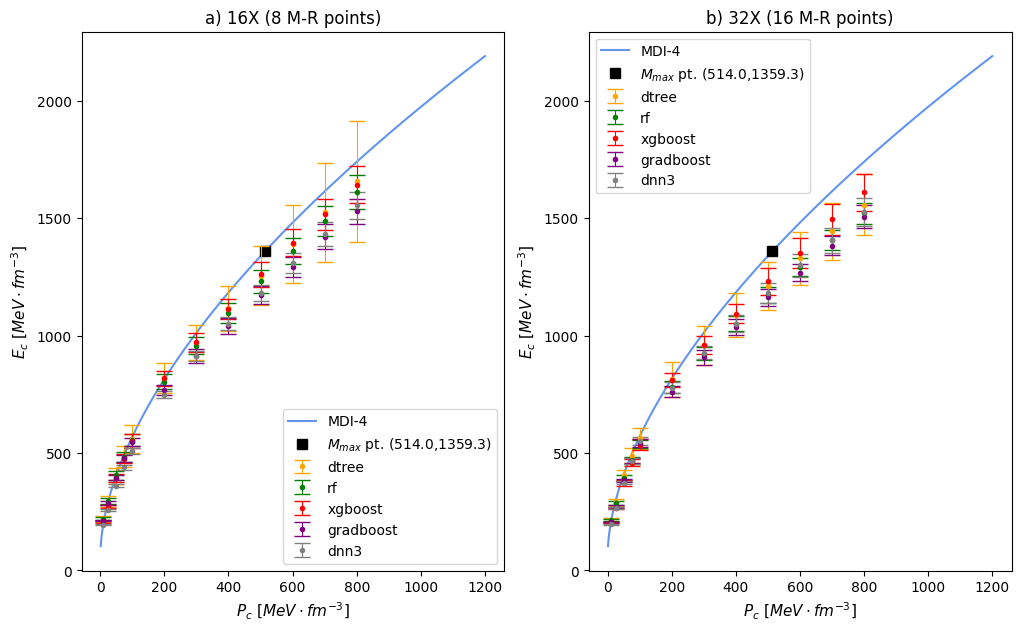

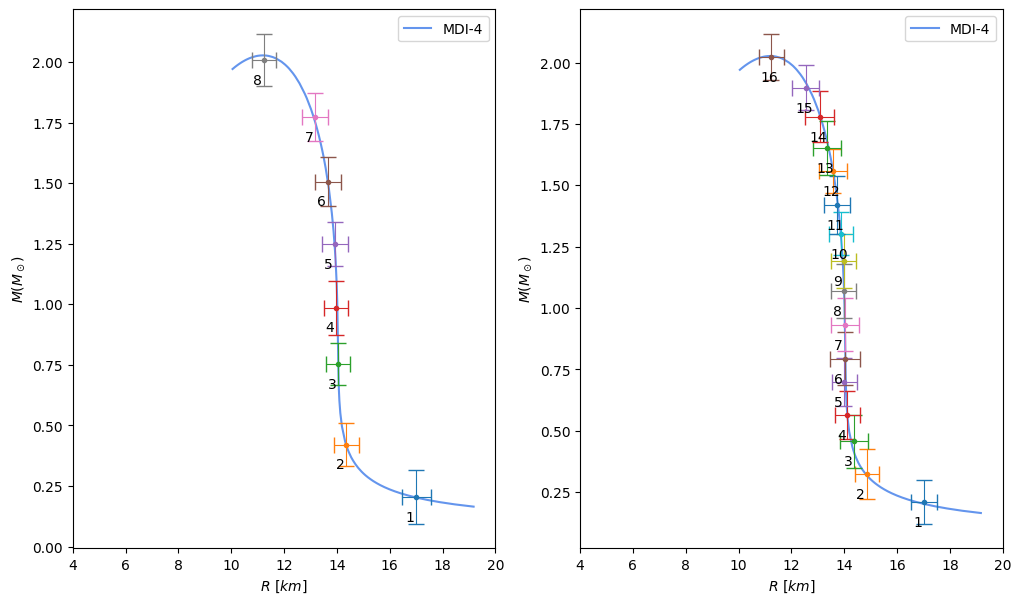

In [20]:
fig_MDI4_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MDI4_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="MDI-4",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="MDI-4",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MDI4_EOS.savefig("MDI-4_EOS_predict.pdf",dpi=300)

## **4.14 NLD results**

> NLD

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.02220480770826604
rf:  0.012653794448239613
xgboost:  0.009024912687993667
gradboost:  0.016486134886390107
dnn3:  0.008401307035210444
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.008401307035210444
---------------------------------------------------------------------


> NLD

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.030935586908539897
rf:  0.01507707605246586
xgboost:  0.010396829993833652
gradboost:  0.017019665266000118
dnn3:  0.008393233263091235
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.008393233263091235
---------------------------------------------------------------------




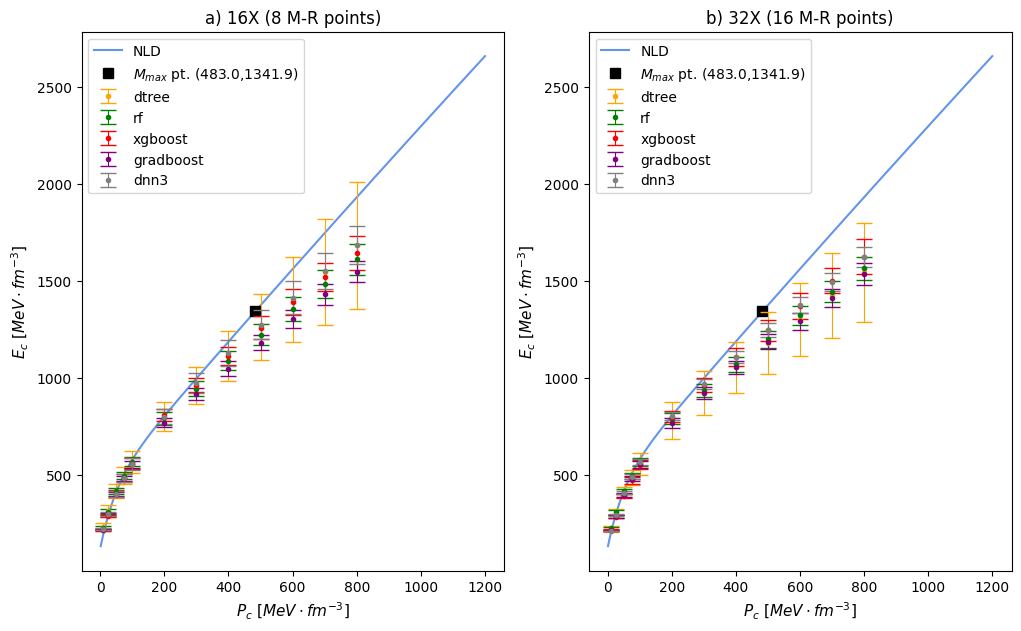

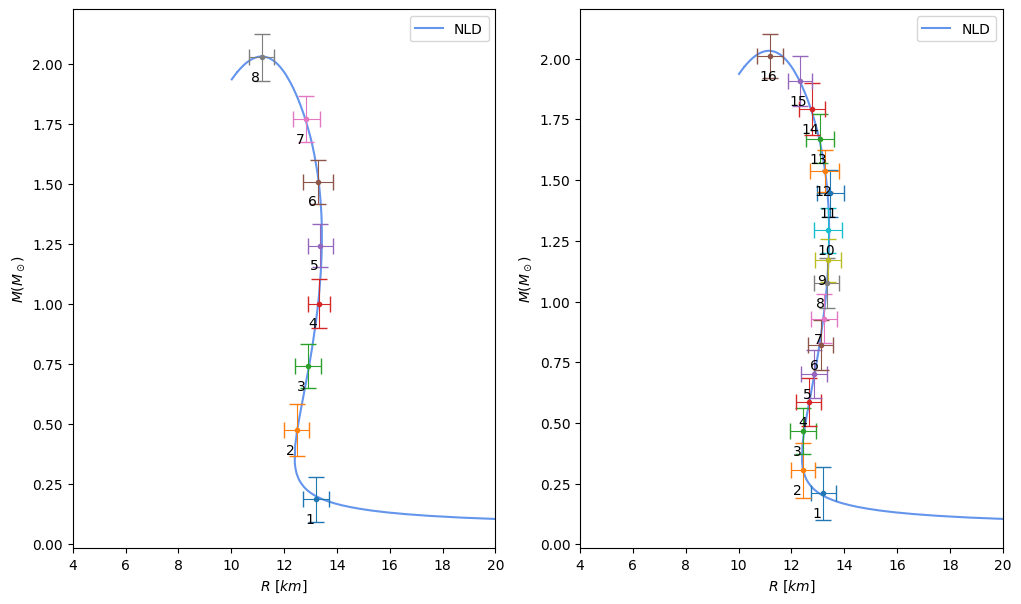

In [21]:
fig_NLD_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_NLD_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="NLD",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="NLD",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_NLD_EOS.savefig("NLD_EOS_predict.pdf",dpi=300)

## **4.15 PS results**

> PS

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.050899877640221504
rf:  0.04491902965269081
xgboost:  0.03228189568671359
gradboost:  0.030347888712961017
dnn3:  0.04524584887363322
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.030347888712961017
---------------------------------------------------------------------


> PS

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.04450012936957318
rf:  0.03513845001698441
xgboost:  0.033227165138580324
gradboost:  0.029845583368063044
dnn3:  0.03612714188694335
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.029845583368063044
---------------------------------------------------------------------




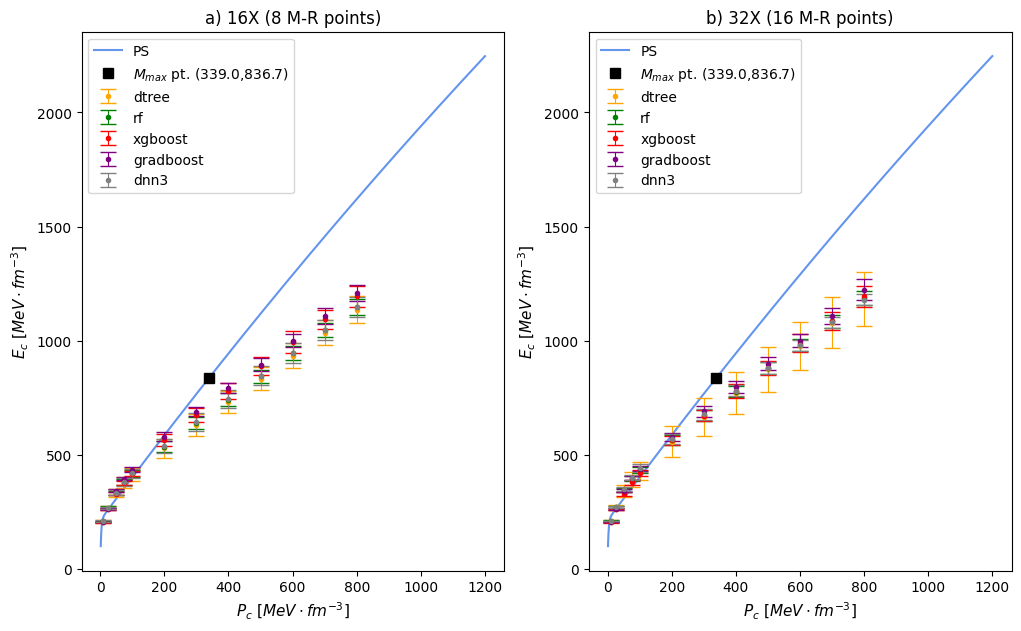

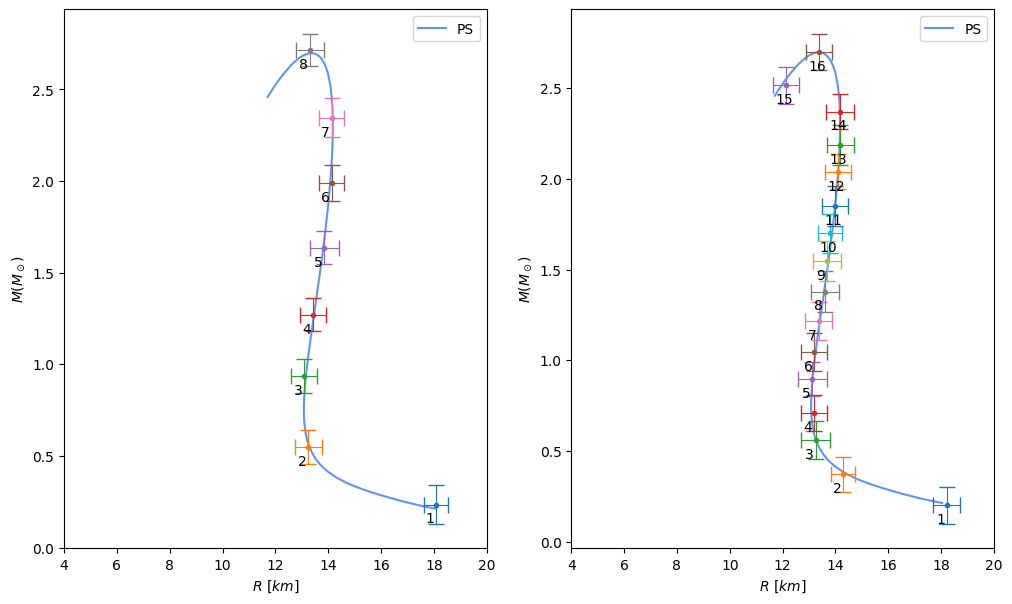

In [22]:
fig_PS_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_PS_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="PS",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="PS",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_PS_EOS.savefig("PS_EOS_predict.pdf",dpi=300)

## **2.16 SCVBB results**

> SCVBB

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.016407314423959683
rf:  0.00254155257794946
xgboost:  0.0024435995519376482
gradboost:  0.0013400620283116275
dnn3:  0.002939521738986529
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.0013400620283116275
---------------------------------------------------------------------


> SCVBB

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.012897355008833161
rf:  0.0015312579102839572
xgboost:  0.0021224631590735133
gradboost:  0.0009532445191357472
dnn3:  0.0020717201013335878
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.0009532445191357472
---------------------------------------------------------------------




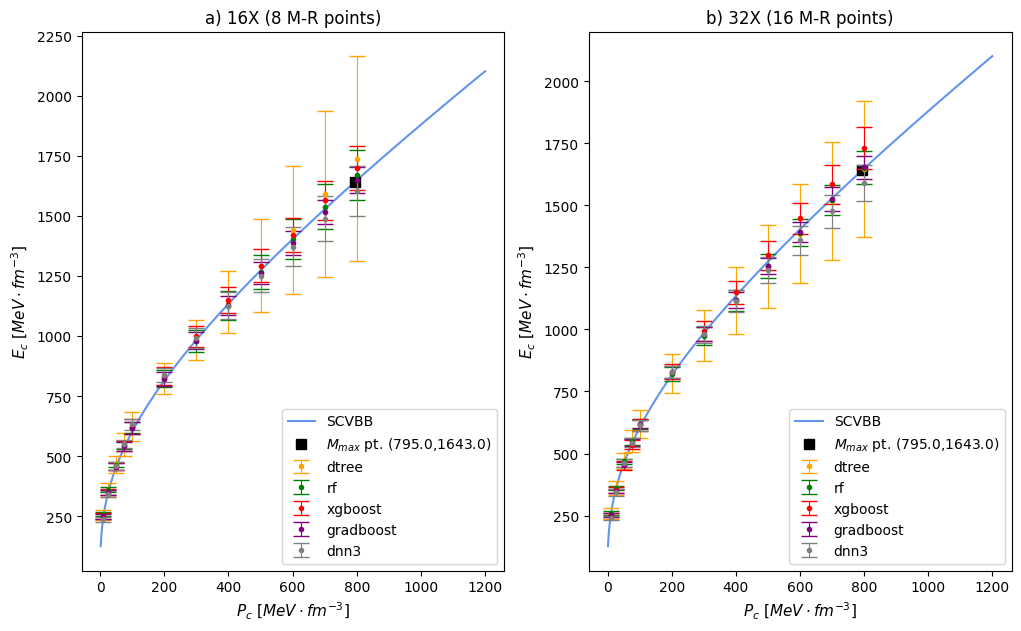

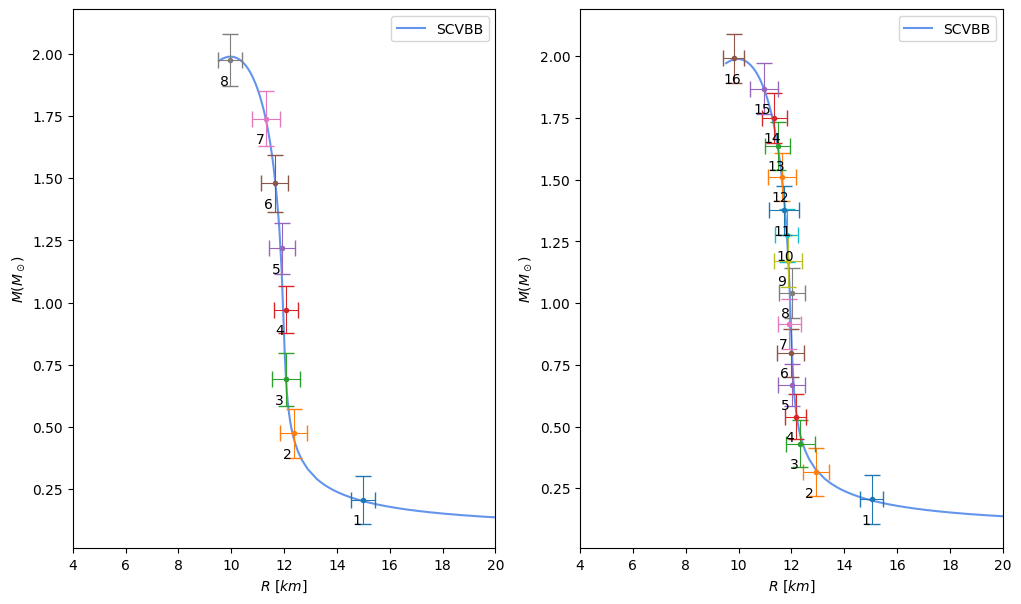

In [23]:
fig_SCVBB_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_SCVBB_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="SCVBB",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="SCVBB",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_SCVBB_EOS.savefig("SCVBB_EOS_predict.pdf",dpi=300)

## **2.17 Ska results**

> Ska

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.010492561424763727
rf:  0.0020960826077303135
xgboost:  0.0027415356682415066
gradboost:  0.001896579726034542
dnn3:  0.0034385885176644333
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.001896579726034542
---------------------------------------------------------------------


> Ska

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.010678530144039964
rf:  0.002170740097707989
xgboost:  0.0030985538866875727
gradboost:  0.00302823210337274
dnn3:  0.0010301044750012929
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0010301044750012929
---------------------------------------------------------------------




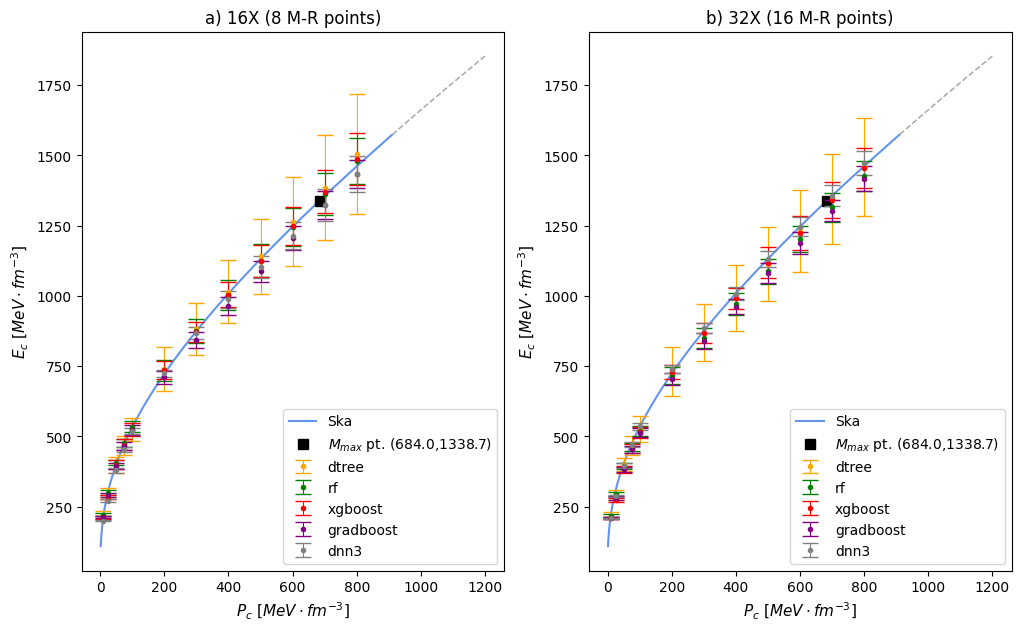

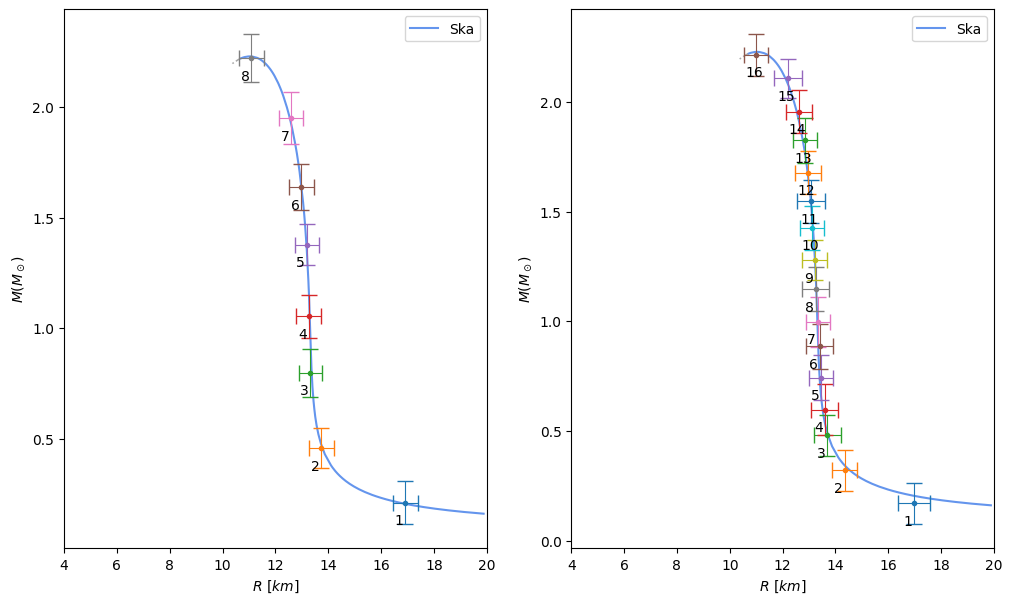

In [24]:
fig_Ska_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_Ska_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="Ska",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="Ska",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_Ska_EOS.savefig("Ska_EOS_predict.pdf",dpi=300)

## **4.18 SkI4 results**

> SkI4

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01012278479941319
rf:  0.00243258495085647
xgboost:  0.002763767163292614
gradboost:  0.0014053993779918172
dnn3:  0.0020381367864886475
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.0014053993779918172
---------------------------------------------------------------------


> SkI4

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.014073920170242305
rf:  0.0016113458918275432
xgboost:  0.001784769389945649
gradboost:  0.0011713884878345434
dnn3:  0.0014982370161923941
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.0011713884878345434
---------------------------------------------------------------------




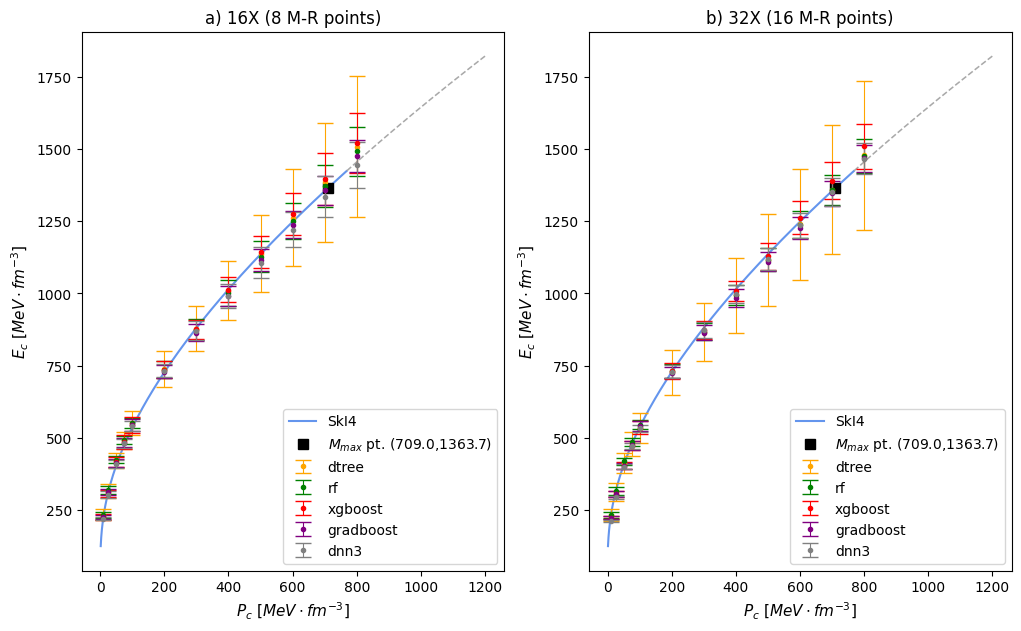

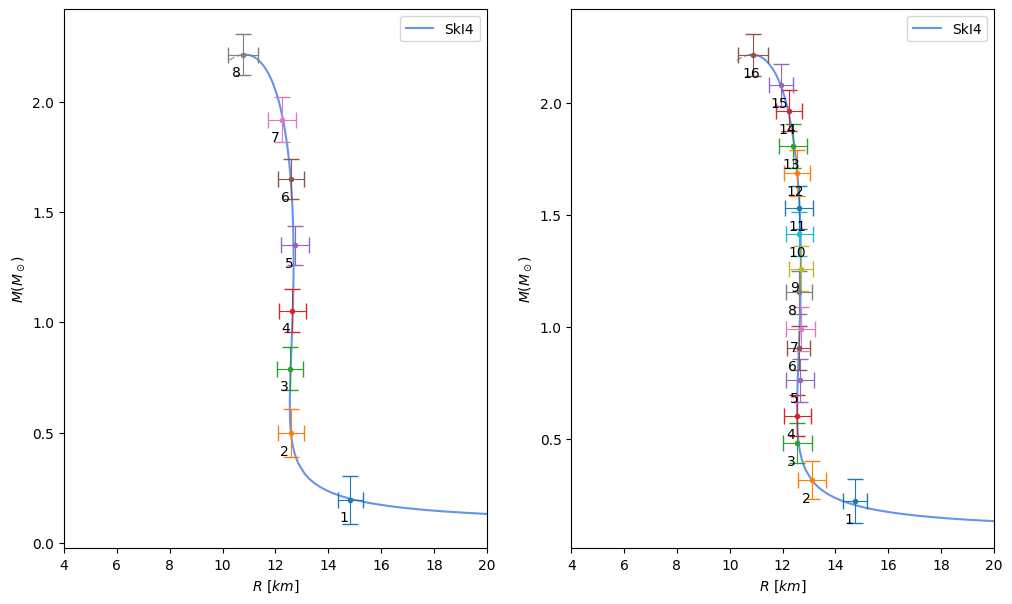

In [25]:
fig_SkI4_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_SkI4_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="SkI4",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="SkI4",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_SkI4_EOS.savefig("SkI4_EOS_predict.pdf",dpi=300)

## **4.19 W results**

> W

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01382043825159903
rf:  0.01076254213796264
xgboost:  0.005609124300458539
gradboost:  0.004961036283491798
dnn3:  0.009643964597076934
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.004961036283491798
---------------------------------------------------------------------


> W

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.020675882524452845
rf:  0.014209117924085676
xgboost:  0.007323014565803136
gradboost:  0.005885210806713684
dnn3:  0.006996295762078698
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.005885210806713684
---------------------------------------------------------------------




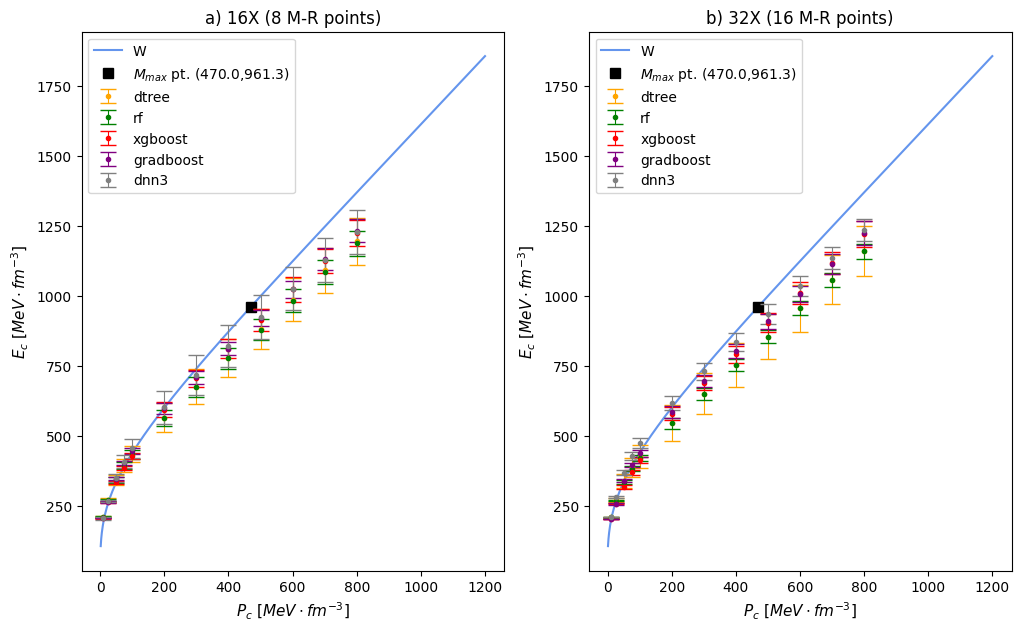

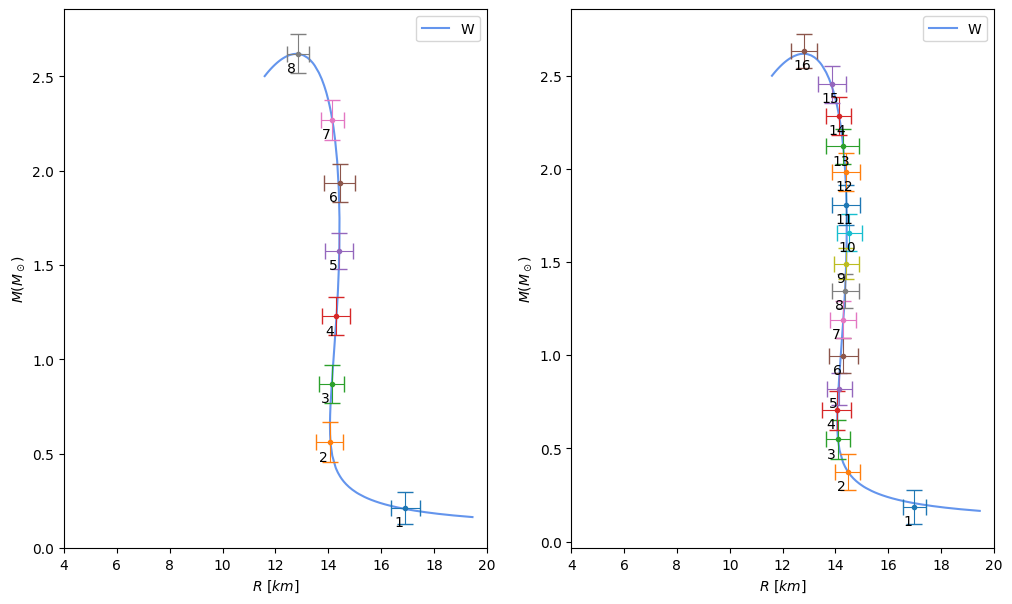

In [26]:
fig_W_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_W_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="W",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="W",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_W_EOS.savefig("W_EOS_predict.pdf",dpi=300)

## **4.20 WFF-1 results**

> WFF-1

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.008170599618886684
rf:  0.003740181457149433
xgboost:  0.002993446516085902
gradboost:  0.0045692043141685795
dnn3:  0.0026158530030717247
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0026158530030717247
---------------------------------------------------------------------


> WFF-1

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01250606714802064
rf:  0.003736718737338563
xgboost:  0.003224868227995657
gradboost:  0.004537852263932567
dnn3:  0.002516933759958241
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.002516933759958241
---------------------------------------------------------------------




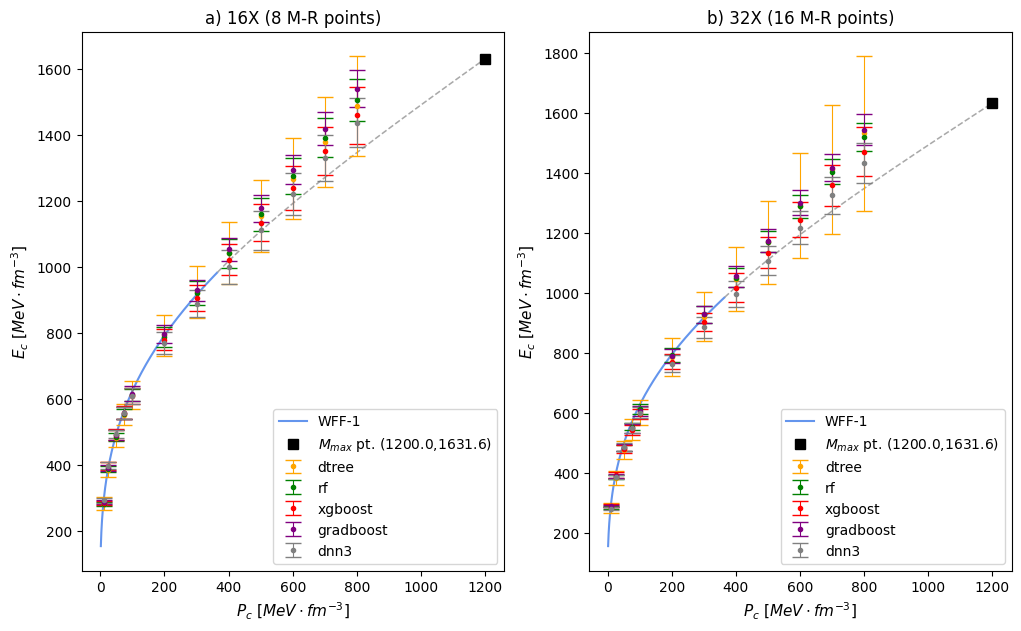

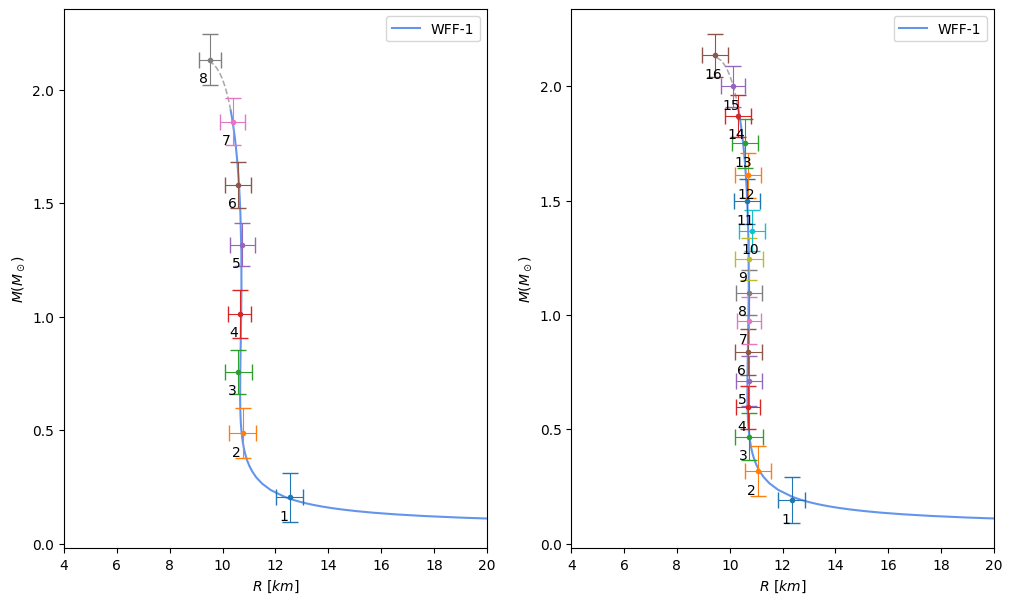

In [27]:
fig_WFF1_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_WFF1_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="WFF-1",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="WFF-1",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_WFF1_EOS.savefig("WFF-1_EOS_predict.pdf",dpi=300)

## **4.21 WFF-2 results**

> WFF-2

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.007728669257690335
rf:  0.002810762635421512
xgboost:  0.0035326344510354132
gradboost:  0.005348085879658587
dnn3:  0.0018319737558625026
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0018319737558625026
---------------------------------------------------------------------


> WFF-2

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.014195867040005063
rf:  0.0034058141752569726
xgboost:  0.00435427311866381
gradboost:  0.004614303665233101
dnn3:  0.0016221724086717935
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0016221724086717935
---------------------------------------------------------------------




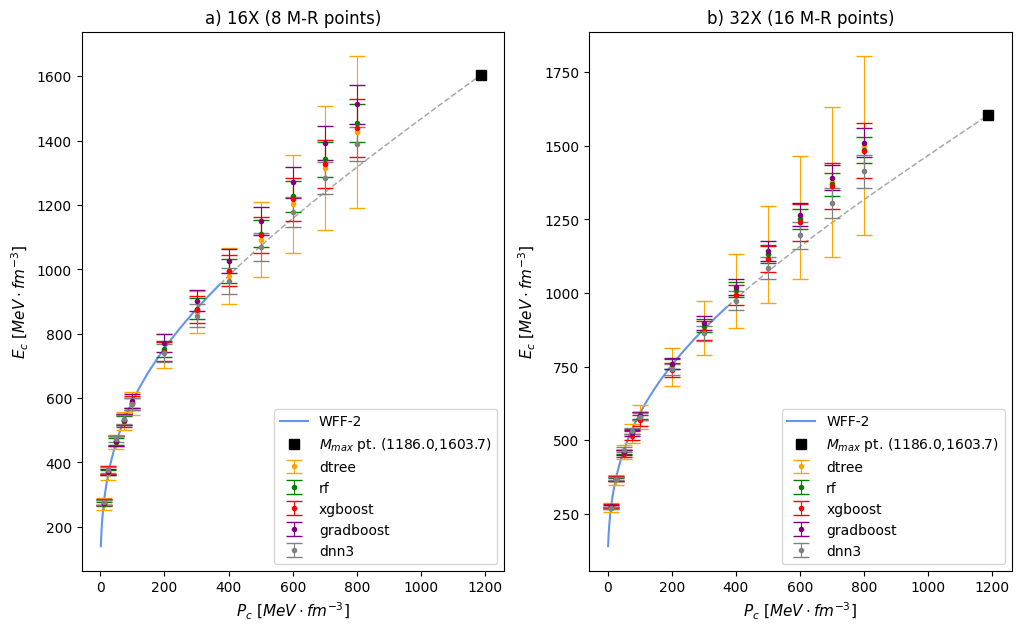

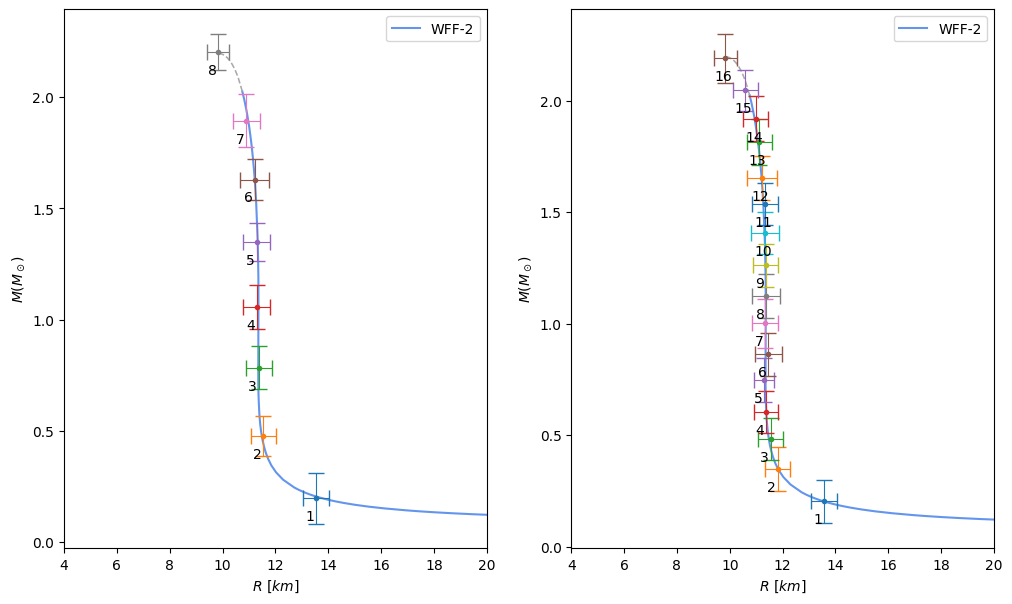

In [28]:
fig_WFF2_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_WFF2_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],main_EOS="WFF-2",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mainNS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],main_EOS="WFF-2",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_WFF1_EOS.savefig("WFF-2_EOS_predict.pdf",dpi=300)